In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv


# Loading The Dataset

In [8]:
train_df = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv")
test_df = pd.read_csv("/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv")

In [9]:
print(train_df.shape)

(116023, 52)


In [10]:
print(test_df.shape)

(29006, 51)


# Importing Neccessary Libraries

In [11]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

from sklearn.metrics import r2_score

# Exploratory Data Anlysis (EDA)

In [12]:
train_df.head()

,trafficSource.isTrueDirect,purchaseValue,browser,device.screenResolution,trafficSource.adContent,trafficSource.keyword,screenSize,geoCluster,trafficSource.adwordsClickInfo.slot,device.mobileDeviceBranding,...,device.language,deviceType,userChannel,device.browserVersion,totalHits,device.screenColors,sessionStart,geoNetwork.continent,device.isMobile,new_visits
0,NaN,0.0,Edge,not available in demo dataset,NaN,NaN,medium,Region_2,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1500100799,Americas,False,1.0
1,True,0.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Direct,not available in demo dataset,1,not available in demo dataset,1495262065,Americas,False,1.0
2,True,0.0,Chrome,not available in demo dataset,NaN,(not provided),medium,Region_2,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Organic Search,not available in demo dataset,6,not available in demo dataset,1508510328,Europe,False,NaN
3,NaN,0.0,Internet Explorer,not available in demo dataset,NaN,NaN,medium,Region_4,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1483431838,Asia,False,1.0
4,True,88950000.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Direct,not available in demo dataset,66,not available in demo dataset,1475804633,Americas,False,1.0


In [13]:
test_df.head()

,userChannel,date,browser,device.browserSize,device.browserVersion,deviceType,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,...,trafficSource,sessionId,sessionNumber,sessionStart,userId,locationZone,geoCluster,browserMajor,screenSize,gclIdPresent
0,Social,20170508,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,...,groups.google.com,1494262567,2,1494262567,59555,8,Region_2,not available in demo dataset,medium,0
1,Organic Search,20170405,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,...,google,1491433811,1,1491433811,6394,8,Region_1,not available in demo dataset,medium,0
2,Organic Search,20170308,Safari,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,...,google,1489001815,1,1489001815,38969,8,Region_5,not available in demo dataset,medium,0
3,Referral,20171113,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,...,docs.google.com,1510593024,30,1510593024,120027,8,Region_2,not available in demo dataset,medium,0
4,Organic Search,20161212,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,...,(direct),1481559809,1,1481559809,69453,8,Region_3,not available in demo dataset,medium,0


In [14]:
data_info = train_df.info()
data_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 52 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   trafficSource.isTrueDirect                    42890 non-null   object 
 1   purchaseValue                                 116023 non-null  float64
 2   browser                                       116023 non-null  object 
 3   device.screenResolution                       116023 non-null  object 
 4   trafficSource.adContent                       2963 non-null    object 
 5   trafficSource.keyword                         44162 non-null   object 
 6   screenSize                                    116023 non-null  object 
 7   geoCluster                                    116023 non-null  object 
 8   trafficSource.adwordsClickInfo.slot           4281 non-null    object 
 9   device.mobileDeviceBranding                   11

- There are four kinds of data types present in training set - **Integer, Float, Boolean and Object**
- Object - 37 Obseravtion
- Integer - 9 Observation
- Float - 5 Observation
- Boolean - 1 Observation

In [15]:
data_description = train_df.describe().T
data_description

,count,mean,std,min,25%,50%,75%,max
purchaseValue,116023.0,2.656393e+07,2.051825e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.312950e+10
userId,116023.0,6.109436e+04,3.524076e+04,0.000000e+00,3.060350e+04,6.101400e+04,9.161650e+04,1.222760e+05
gclIdPresent,116023.0,3.701852e-02,1.888080e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
sessionNumber,116023.0,2.691311e+00,1.045161e+01,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.470000e+02
totals.visits,116023.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
sessionId,116023.0,1.493429e+09,1.528798e+07,1.470035e+09,1.480066e+09,1.491646e+09,1.505079e+09,1.525157e+09
trafficSource.adwordsClickInfo.page,4281.0,1.019622e+00,1.745165e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.000000e+00
pageViews,116015.0,8.412352e+00,1.434494e+01,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+01,4.690000e+02
locationZone,116023.0,8.000000e+00,0.000000e+00,8.000000e+00,8.000000e+00,8.000000e+00,8.000000e+00,8.000000e+00
totals.bounces,47148.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [16]:
null_column = ((train_df.isnull().sum()/train_df.shape[0]*100)).sort_values(ascending=False)
null_column

trafficSource.adContent                         97.446196
trafficSource.adwordsClickInfo.isVideoAd        96.310214
trafficSource.adwordsClickInfo.page             96.310214
trafficSource.adwordsClickInfo.adNetworkType    96.310214
trafficSource.adwordsClickInfo.slot             96.310214
trafficSource.referralPath                      63.184886
trafficSource.isTrueDirect                      63.033192
trafficSource.keyword                           61.936857
totals.bounces                                  59.363230
new_visits                                      30.601691
pageViews                                        0.006895
device.mobileInputSelector                       0.000000
date                                             0.000000
geoNetwork.city                                  0.000000
screenSize                                       0.000000
geoNetwork.metro                                 0.000000
locationZone                                     0.000000
device.mobileD


- Columns Like **trafficSource.adContent , trafficSource.adwordsClickInfo.isVideoAd , trafficSource.adwordsClickInfo.page , trafficSource.adwordsClickInfo.adNetworkType , trafficSource.adwordsClickInfo.slot** Contains more than 90 % missing values , making them seem largely uninformative.

In [17]:
df = train_df.copy()

## Analysis of Categorical Column

In [18]:
for each in df.select_dtypes(object).columns.tolist() :
    print(each)

trafficSource.isTrueDirect
browser
device.screenResolution
trafficSource.adContent
trafficSource.keyword
screenSize
geoCluster
trafficSource.adwordsClickInfo.slot
device.mobileDeviceBranding
device.mobileInputSelector
trafficSource.campaign
device.mobileDeviceMarketingName
geoNetwork.networkDomain
device.operatingSystemVersion
device.flashVersion
geoNetwork.region
trafficSource
geoNetwork.networkLocation
os
geoNetwork.subContinent
trafficSource.medium
trafficSource.adwordsClickInfo.isVideoAd
browserMajor
locationCountry
device.browserSize
trafficSource.adwordsClickInfo.adNetworkType
socialEngagementType
geoNetwork.city
geoNetwork.metro
device.mobileDeviceModel
trafficSource.referralPath
device.language
deviceType
userChannel
device.browserVersion
device.screenColors
geoNetwork.continent


**1. trafficSource.isTrueDirect** 

In [19]:
df['trafficSource.isTrueDirect'].nunique()

1

In [20]:
df['trafficSource.isTrueDirect'].unique()

array([nan, True], dtype=object)

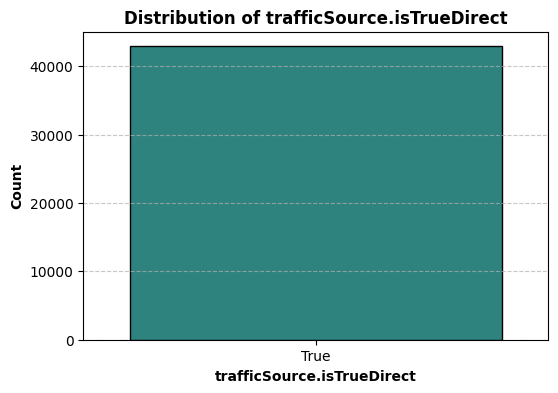

In [21]:
plt.figure(figsize=(6, 4))
sns.countplot(x='trafficSource.isTrueDirect', data=df, palette= 'viridis' , edgecolor = 'black')
plt.title('Distribution of trafficSource.isTrueDirect', fontweight='bold')
plt.xlabel('trafficSource.isTrueDirect' , fontweight = 'bold')
plt.ylabel('Count' , fontweight = 'bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

- **trafficSource.isTrueDirect** has 63% null values and for the remaining column only **True** is present.

**2. browser**

In [22]:
df['browser'].unique()

array(['Edge', 'Chrome', 'Internet Explorer', 'Safari', 'Android Webview',
       'Firefox', 'Opera', 'Opera Mini', 'UC Browser', 'Nintendo Browser',
       'Safari (in-app)', 'Iron', 'Samsung Internet', 'YaBrowser',
       'Android Browser', 'MRCHROME', 'Coc Coc',
       'Mozilla Compatible Agent', 'Amazon Silk', 'Maxthon', 'BlackBerry',
       'Seznam', 'Nokia Browser', 'M5', 'Puffin', 'Mozilla',
       'LYF_LS_4002_12', 'MQQBrowser', 'Browser', 'osee2unifiedRelease',
       '(not set)',
       ';__CT_JOB_ID__:85da5736-a78e-45a9-837e-f5a53e5cd725;',
       'Playstation Vita Browser', 'no-ua'], dtype=object)

In [23]:
df['browser'].nunique()

34

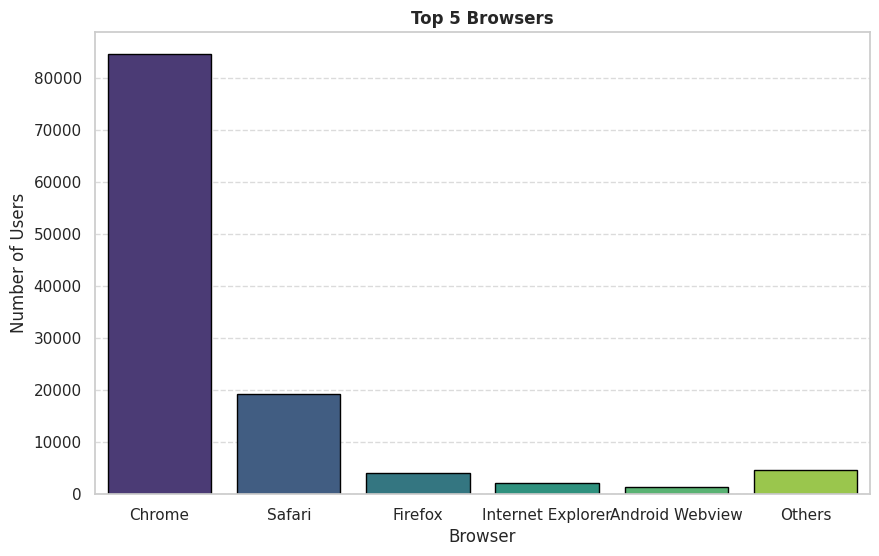

In [24]:
browser_counts = df['browser'].value_counts()
top_5 = browser_counts.head(5)
others_count = browser_counts[5:].sum()
browser_grouped = pd.concat([top_5, pd.Series({'Others': others_count})])

sns.set(style = 'whitegrid')
plt.figure(figsize = (10, 6))
sns.barplot(x = browser_grouped.index, y = browser_grouped.values, palette = 'viridis',edgecolor = 'black')

plt.title('Top 5 Browsers',fontweight='bold')
plt.xlabel('Browser')
plt.ylabel('Number of Users')
plt.grid(axis = 'y', linestyle='--', alpha = 0.7)

plt.show()

- **Chrome** is the most used browser among 34 other unique values present in the browser column.
- Followed by **Safari** and **Firefox**

**3. device.screenResolution**

In [25]:
df['device.screenResolution'].nunique()

1

In [26]:
df['device.screenResolution'].unique()

array(['not available in demo dataset'], dtype=object)

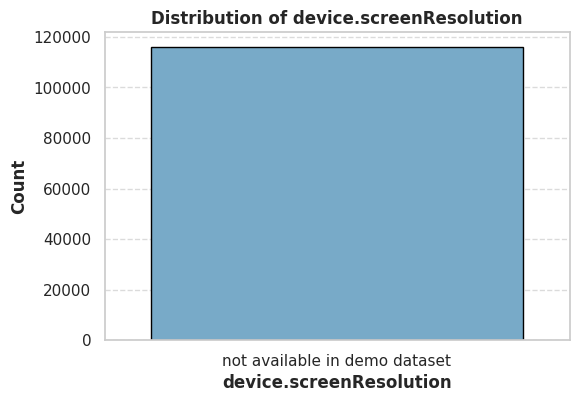

In [27]:
plt.figure(figsize=(6, 4))
sns.countplot(x='device.screenResolution', data=df, palette= 'Blues' , edgecolor = 'black')
plt.title('Distribution of device.screenResolution', fontweight='bold')
plt.xlabel('device.screenResolution' , fontweight = 'bold')
plt.ylabel('Count' , fontweight = 'bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**4. ScreenSize**

In [28]:
df['screenSize'].nunique()

1

In [29]:
df['screenSize'].unique()

array(['medium'], dtype=object)

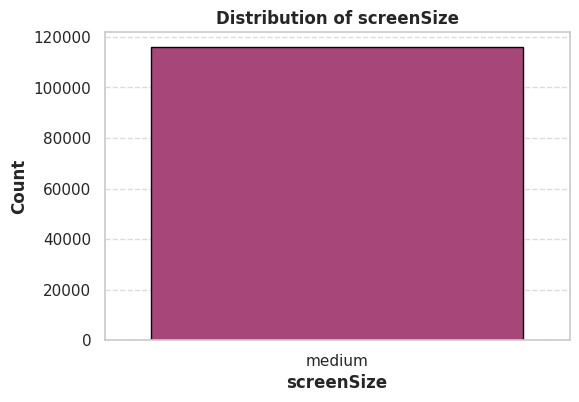

In [30]:
plt.figure(figsize=(6, 4))
sns.countplot(x='screenSize', data=df, palette= 'magma' , edgecolor = 'black')
plt.title('Distribution of screenSize', fontweight='bold')
plt.xlabel('screenSize' , fontweight = 'bold')
plt.ylabel('Count' , fontweight = 'bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**5. Geo Cluster**

In [31]:
df ['geoCluster'].nunique()

5

In [32]:
df ['geoCluster'].unique()

array(['Region_2', 'Region_3', 'Region_4', 'Region_5', 'Region_1'],
      dtype=object)

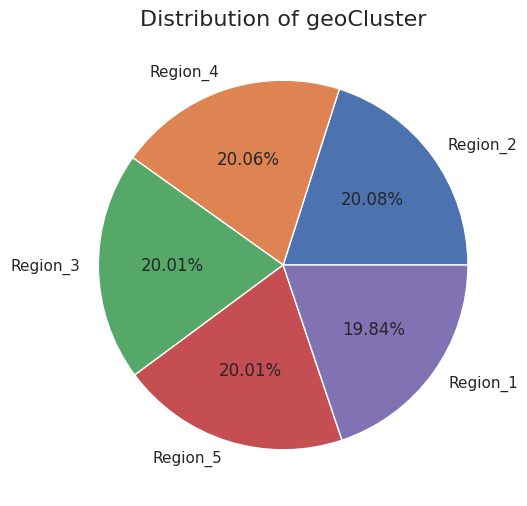

In [33]:
geo_counts = df['geoCluster'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie( geo_counts, labels=geo_counts.index , autopct='%1.2f%%')

plt.title('Distribution of geoCluster', fontsize=16)
plt.show()

- The dataset is uniformly sampled across all five regions, with each region accounting for approximately 20%

**6. device.mobileDeviceBranding**

In [34]:
df["device.mobileDeviceBranding"].nunique()

1

In [35]:
df["device.mobileDeviceBranding"].unique()

array(['not available in demo dataset'], dtype=object)

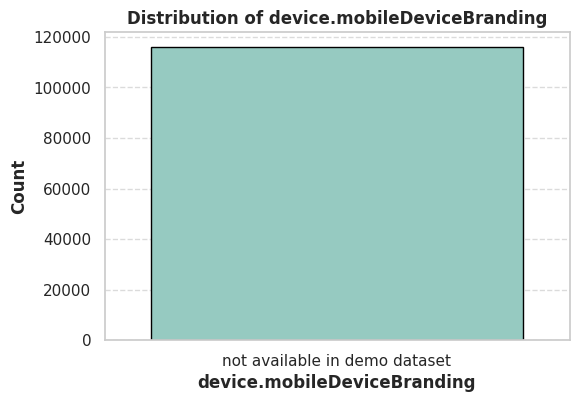

In [36]:
plt.figure(figsize=(6, 4))
sns.countplot(x='device.mobileDeviceBranding', data=df, palette= 'Set3' , edgecolor = 'black')
plt.title('Distribution of device.mobileDeviceBranding', fontweight='bold')
plt.xlabel('device.mobileDeviceBranding' , fontweight = 'bold')
plt.ylabel('Count' , fontweight = 'bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**7. trafficSource.campaign**

In [37]:
df["trafficSource.campaign"].nunique()

28

In [38]:
df["trafficSource.campaign"].unique()

array(['(not set)', 'Data Share Promo', 'AW - Accessories',
       'AW - Dynamic Search Ads Whole Site',
       '1000557 | GA | US | en | Hybrid | GDN Remarketing',
       '1000557 | GA | US | en | Hybrid | GDN Text+Banner | AS',
       'Page: contains "/google+redesign/bags" All Users Similar Audiences',
       'Technology/Technophiles', 'Smart Display Campaign',
       'Page: contains "/google+redesign/drinkware" Similar Audiences',
       'Page: contains "/google+redesign/electronics"',
       'Sports & Fitness/Health & Fitness Buffs',
       'Page: contains "/google+redesign/drinkware"',
       'Value Shoppers Affinity',
       '"google + redesign/Accessories March 17" All Users',
       'test-liyuhz', 'Run of Network Line Item',
       '"google + redesign/Accessories March 17" All Users Similar Audiences',
       'Page: contains "/google+redesign/office" Similar Audiences',
       'Technology/Mobile Enthusiasts',
       'Lifestyles & Hobbies/Shutterbugs', 'AW - Electronics',
     

**8. device.mobileDeviceMarketingName**

In [39]:
df["device.mobileDeviceMarketingName"].nunique()

1

In [40]:
df["device.mobileDeviceMarketingName"].unique()

array(['not available in demo dataset'], dtype=object)

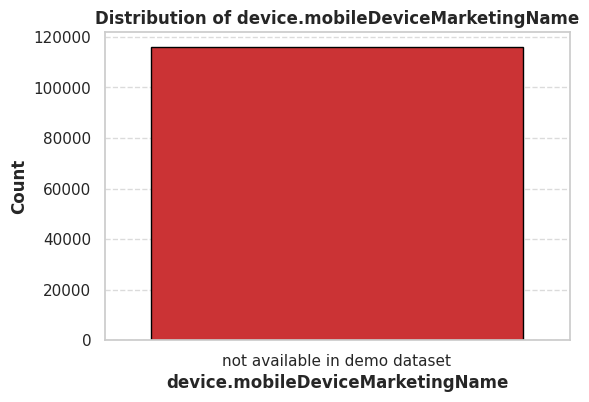

In [41]:
plt.figure(figsize=(6, 4))
sns.countplot(x='device.mobileDeviceMarketingName', data=df, palette= 'Set1' , edgecolor = 'black')
plt.title('Distribution of device.mobileDeviceMarketingName', fontweight='bold')
plt.xlabel('device.mobileDeviceMarketingName' , fontweight = 'bold')
plt.ylabel('Count' , fontweight = 'bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**9. geoNetwork.networkDomain**

In [42]:
df['geoNetwork.networkDomain'].nunique()

3

In [43]:
df['geoNetwork.networkDomain'].unique()

array(['domain1', 'domain3', 'domain2'], dtype=object)

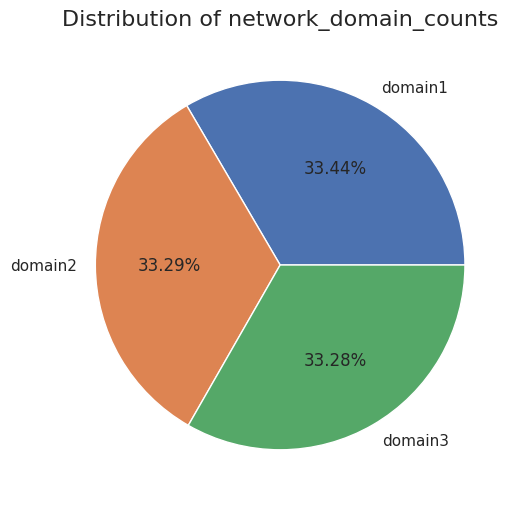

In [44]:
network_domain_counts = df['geoNetwork.networkDomain'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie( network_domain_counts, labels=network_domain_counts.index , autopct='%1.2f%%')

plt.title('Distribution of network_domain_counts', fontsize=16)
plt.show()

- The distribution of **geoNetwork.networkDomai**n is nearly uniform across domain1, domain2, and domain3, each contributing roughly one-third of the total.

**10. device.operatingSystemVersion**

In [45]:
df['device.operatingSystemVersion'].nunique()

1

In [46]:
df['device.operatingSystemVersion'].unique()

array(['not available in demo dataset'], dtype=object)

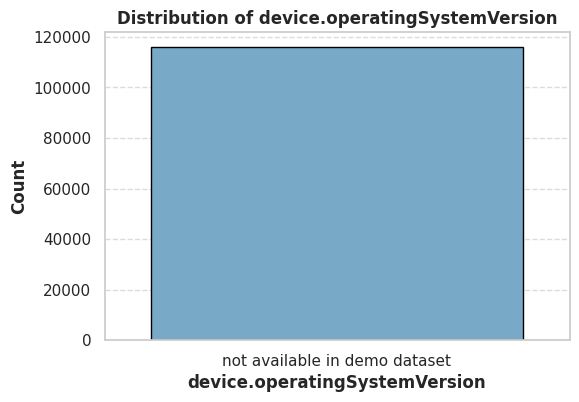

In [47]:
plt.figure(figsize=(6, 4))
sns.countplot(x='device.operatingSystemVersion', data=df, palette= 'Blues' , edgecolor = 'black')
plt.title('Distribution of device.operatingSystemVersion', fontweight='bold')
plt.xlabel('device.operatingSystemVersion' , fontweight = 'bold')
plt.ylabel('Count' , fontweight = 'bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**11. device.flashVersion**

In [48]:
df['device.flashVersion'].nunique()

1

In [49]:
df['device.flashVersion'].unique()

array(['not available in demo dataset'], dtype=object)

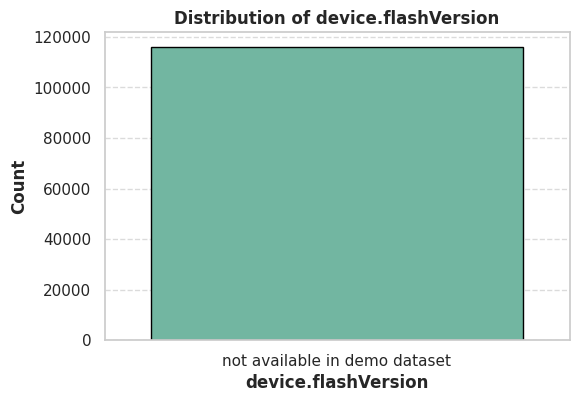

In [50]:
plt.figure(figsize=(6, 4))
sns.countplot(x='device.flashVersion', data=df, palette= 'Set2' , edgecolor = 'black')
plt.title('Distribution of device.flashVersion', fontweight='bold')
plt.xlabel('device.flashVersion' , fontweight = 'bold')
plt.ylabel('Count' , fontweight = 'bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**12. geoNetwork.region**

In [51]:
df['geoNetwork.region'].nunique()

388

In [52]:
df['geoNetwork.region'].unique()

array(['Washington', 'California', 'Lombardy',
       'not available in demo dataset',
       'Federal Territory of Kuala Lumpur', 'Tokyo', '(not set)',
       'State of Sao Paulo', 'Tamil Nadu', 'Nakhon Pathom',
       'Masovian Voivodeship', 'Zurich', 'Istanbul', 'Ontario',
       'Illinois', 'New York', 'Bogota', 'Massachusetts', 'Delhi',
       'Wellington', 'Pennsylvania', 'District of Columbia',
       'Ile-de-France', 'England', 'New South Wales', 'Doha',
       'Maharashtra', 'Arizona', 'Georgia', 'West Java', 'Lagos',
       'Tel Aviv District', 'South Carolina', 'Kyiv city', 'Victoria',
       'Maryland', 'Quebec', 'Lazio', 'Chon Buri', 'Karnataka',
       'Virginia', 'Queensland', 'Makkah Province', 'British Columbia',
       'Ho Chi Minh', 'Bucharest', 'Texas', 'Taipei City',
       'North Holland', 'Michigan', 'State of Minas Gerais',
       'Mexico City', 'Bavaria', 'Telangana', 'Bangkok', 'Minnesota',
       'Punjab', 'Tien Giang', 'Phnom Penh', 'Buenos Aires',
       'A

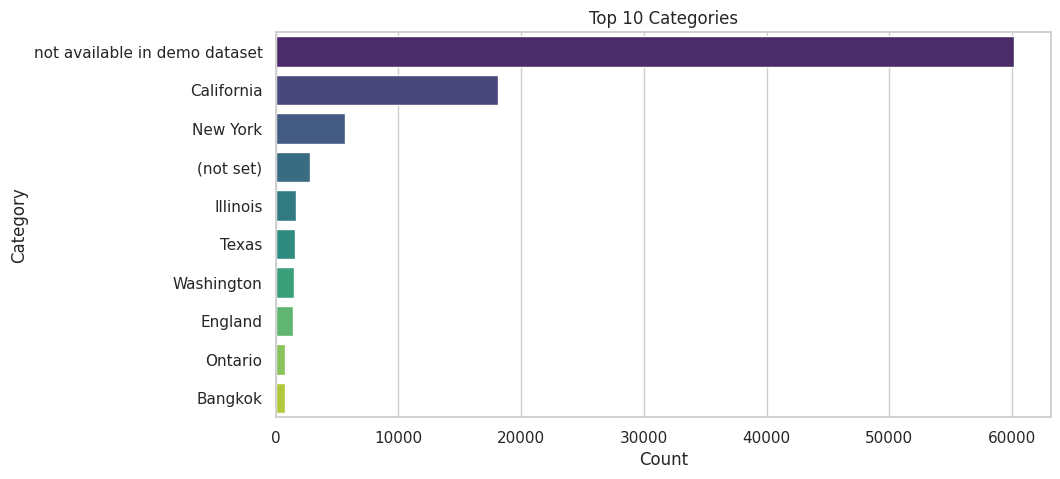

In [53]:
geo_net_region_counts = df['geoNetwork.region'].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=geo_net_region_counts.values, y=geo_net_region_counts.index, palette='viridis')
plt.title('Top 10 Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

- The category "not available in demo dataset" dominates the dataset, with around 60,000 entries, indicating a large portion of location data is missing.
- California, New York, Illinois, Texas, and Washington appear among the top categories, indicating significant data contributions from major urban areas in the United States.

**13. trafficSource**

In [54]:
df['trafficSource'].nunique()

161

In [55]:
df['trafficSource'].unique()

array(['youtube.com', '(direct)', 'google', 'phandroid.com',
       'mall.googleplex.com', 'google.com', 'Partners', 'mail.google.com',
       'yahoo', 'qiita.com', 'sites.google.com', 'dfa', 'bing',
       'reddit.com', 'search.tb.ask.com', 'chat.google.com',
       'groups.google.com', 'msn.com', 't.co', 'duckduckgo.com',
       'plus.url.google.com', 'googleads.g.doubleclick.net',
       'analytics.google.com', 'google.co.uk', 'l.facebook.com',
       'siliconvalley.about.com', 'facebook.com', 'quora.com',
       'sashihara.jp', 'baidu', 'm.facebook.com', 'optimize.google.com',
       'blog.golang.org', 'int.search.tb.ask.com',
       'gdeals.googleplex.com', 'adwords.google.com', 'lunametrics.com',
       'productforums.google.com', 'plus.google.com',
       'trainup.withgoogle.com', 'dealspotr.com', 'google.de',
       'google.co.jp', 'ask', 'aulagrado.esic.edu', 'search.xfinity.com',
       's0.2mdn.net', 'hangouts.google.com', 'online-metrics.com',
       'keep.google.com', 'gat

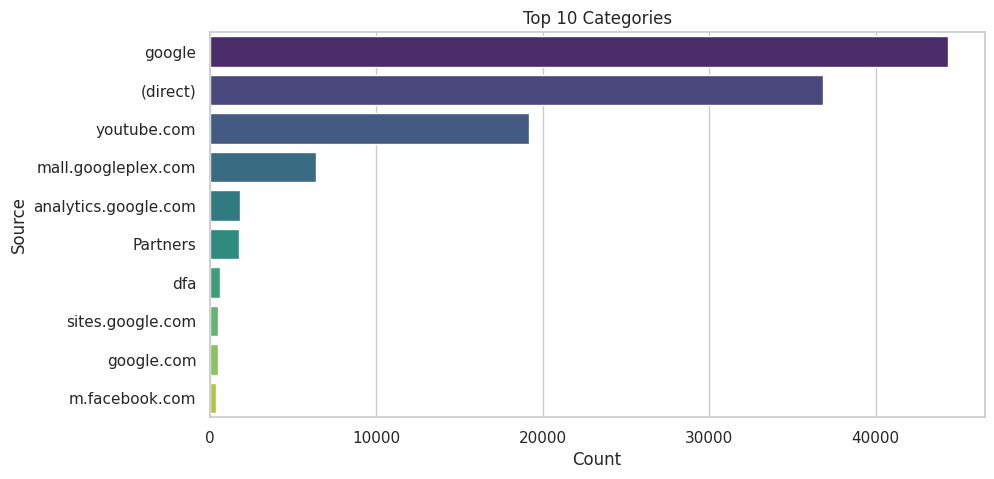

In [56]:
trafficsource_counts = df['trafficSource'].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=trafficsource_counts.values, y=trafficsource_counts.index, palette='viridis')
plt.title('Top 10 Categories')
plt.xlabel('Count')
plt.ylabel('Source')
plt.show()

- The majority of traffic comes from google, making it the most dominant traffic referrer.
- (direct) appears as the second-largest source, indicating that a significant portion of users access the site directly.
- youtube.com ranks third, showing the influence of video content in driving traffic.

**14. geoNetwork.networkLocation**

In [57]:
df['geoNetwork.networkLocation'].nunique()

1

In [58]:
df['geoNetwork.networkLocation'].unique()

array(['not available in demo dataset'], dtype=object)

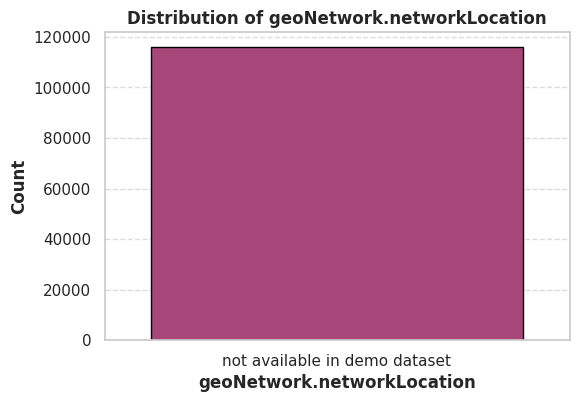

In [59]:
plt.figure(figsize=(6, 4))
sns.countplot(x='geoNetwork.networkLocation', data=df, palette= 'magma' , edgecolor = 'black')
plt.title('Distribution of geoNetwork.networkLocation', fontweight='bold')
plt.xlabel('geoNetwork.networkLocation' , fontweight = 'bold')
plt.ylabel('Count' , fontweight = 'bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**15. OS**

In [60]:
df['os'].nunique()

18

In [61]:
df['os'].unique()

array(['Windows', 'Macintosh', 'Android', 'iOS', 'Chrome OS', 'Linux',
       '(not set)', 'Firefox OS', 'Nintendo Wii', 'Windows Phone',
       'Nintendo WiiU', 'Tizen', 'Samsung', 'BlackBerry', 'OS/2', 'Xbox',
       'Playstation Vita', 'FreeBSD'], dtype=object)

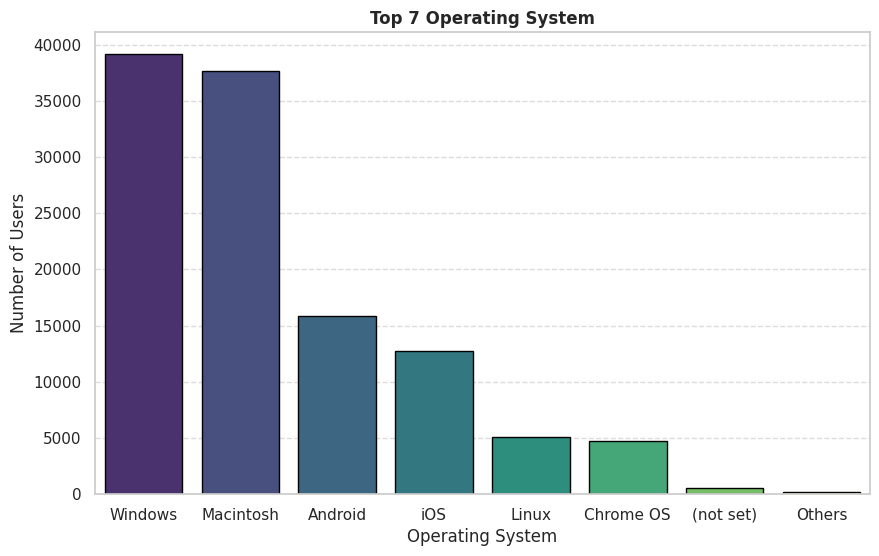

In [62]:
os_counts = df['os'].value_counts()
top_5_os = os_counts.head(7)
others_os_count = os_counts[7:].sum()
os_grouped = pd.concat([top_5_os, pd.Series({'Others': others_os_count})])

sns.set(style = 'whitegrid')
plt.figure(figsize = (10, 6))
sns.barplot(x = os_grouped.index, y = os_grouped.values, palette = 'viridis',edgecolor = 'black')

plt.title('Top 7 Operating System',fontweight='bold')
plt.xlabel('Operating System')
plt.ylabel('Number of Users')
plt.grid(axis = 'y', linestyle='--', alpha = 0.7)

plt.show()

- **Windows** is the most common Operating System used.
- Followed by **Macintosh** **, Android, iOS and Linux**

**16. geoNetwork.subContinent**

In [63]:
df['geoNetwork.subContinent'].nunique()

23

In [64]:
df['geoNetwork.subContinent'].unique()

array(['Northern America', 'Southern Europe', 'Eastern Asia',
       'Southeast Asia', 'South America', 'Southern Asia',
       'Eastern Europe', 'Western Europe', 'Western Asia',
       'Eastern Africa', 'Western Africa', 'Australasia',
       'Northern Europe', 'Central Asia', 'Southern Africa',
       'Central America', 'Northern Africa', 'Caribbean', '(not set)',
       'Micronesian Region', 'Middle Africa', 'Melanesia', 'Polynesia'],
      dtype=object)

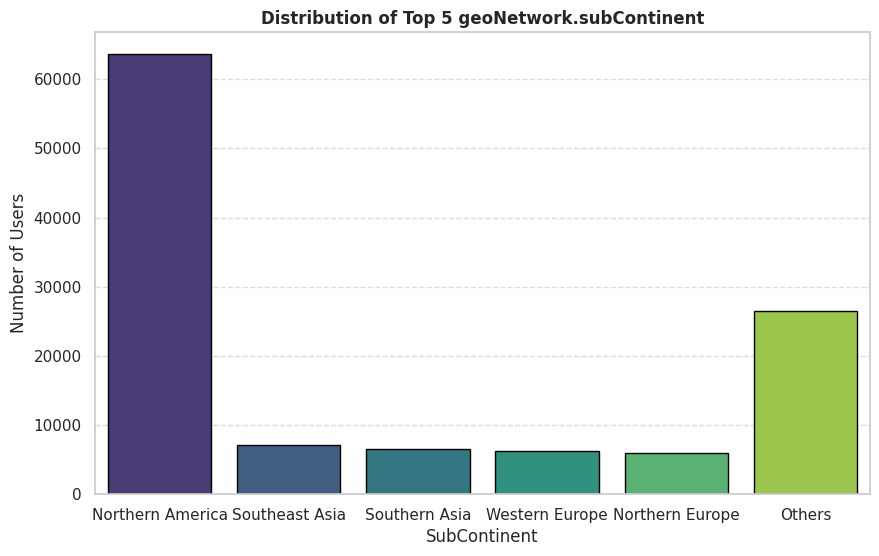

In [65]:
subcontinent_counts = df['geoNetwork.subContinent'].value_counts()
top_5_sc = subcontinent_counts.head(5)
others_sc_count = subcontinent_counts[5:].sum()
sc_grouped = pd.concat([top_5_sc, pd.Series({'Others': others_sc_count})])

sns.set(style = 'whitegrid')
plt.figure(figsize = (10, 6))
sns.barplot(x = sc_grouped.index, y = sc_grouped.values, palette = 'viridis',edgecolor = 'black')

plt.title('Distribution of Top 5 geoNetwork.subContinent',fontweight='bold')
plt.xlabel('SubContinent')
plt.ylabel('Number of Users')
plt.grid(axis = 'y', linestyle='--', alpha = 0.7)

plt.show()

- Most of the user those who are browsing are from **Northern America** subcontinent.
- Then user from **Asian subcontinents** constitutes in the second and third position.
- Followed by users from **European** subcontinent.

**17. trafficSource.medium**

In [66]:
df['trafficSource.medium'].nunique()

7

In [67]:
df['trafficSource.medium'].unique()

array(['referral', '(none)', 'organic', 'affiliate', 'cpc', 'cpm',
       '(not set)'], dtype=object)

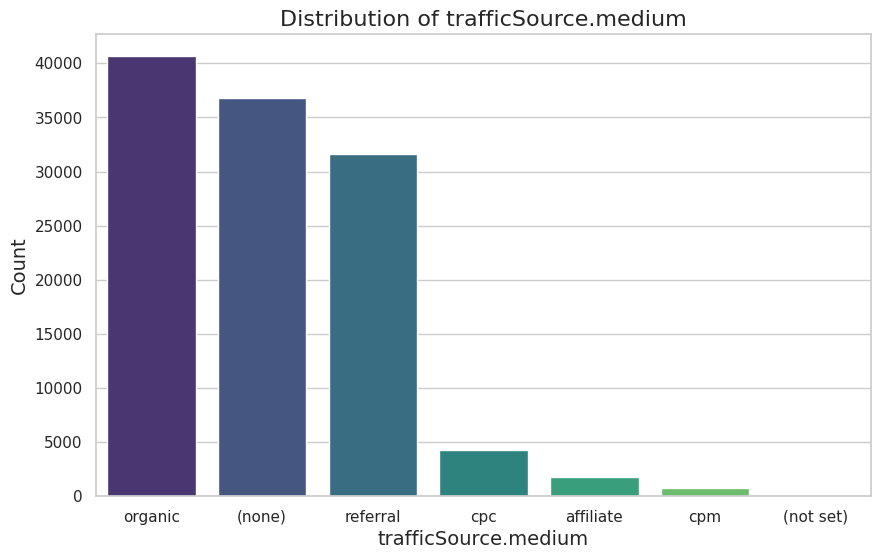

In [68]:
order = df['trafficSource.medium'].value_counts().index

plt.figure(figsize=(10, 6))

sns.countplot(x='trafficSource.medium', data=df, palette='viridis', order=order)
plt.title('Distribution of trafficSource.medium', fontsize=16)
plt.xlabel('trafficSource.medium', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.show()

- Major portion of users are coming from **Organic sources**.
- Then followed by **referral**.
- But very few users are coming via **affiliate**.

**18. browserMajor**

In [69]:
df['browserMajor'].nunique()

1

In [70]:
df['browserMajor'].unique()

array(['not available in demo dataset'], dtype=object)

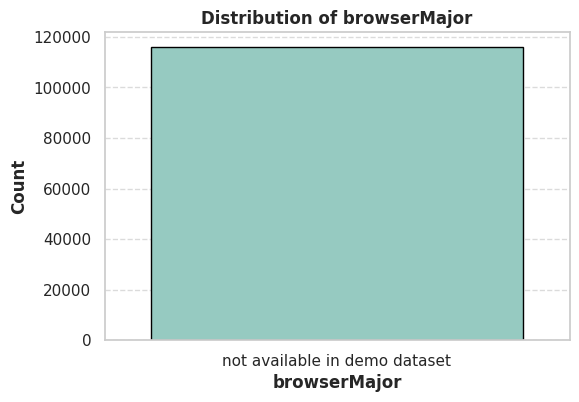

In [71]:
plt.figure(figsize=(6, 4))
sns.countplot(x='browserMajor', data=df, palette= 'Set3' , edgecolor = 'black')
plt.title('Distribution of browserMajor', fontweight='bold')
plt.xlabel('browserMajor' , fontweight = 'bold')
plt.ylabel('Count' , fontweight = 'bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**19. locationCountry**

In [72]:
df['locationCountry'].nunique()

193

In [73]:
df['locationCountry'].unique()

array(['United States', 'Italy', 'Japan', 'Malaysia', 'Hong Kong',
       'Canada', 'Brazil', 'India', 'Thailand', 'Poland', 'France',
       'Switzerland', 'Vietnam', 'Turkey', 'Indonesia', 'Czechia',
       'Colombia', 'Hungary', 'Kenya', 'Nigeria', 'Bulgaria',
       'New Zealand', 'United Kingdom', 'Kazakhstan', 'Romania', 'Latvia',
       'Austria', 'Albania', 'Germany', 'Australia', 'Qatar', 'Belgium',
       'Taiwan', 'Israel', 'South Africa', 'Ukraine',
       'United Arab Emirates', 'Greece', 'Peru', 'Mexico', 'Netherlands',
       'Saudi Arabia', 'Russia', 'Egypt', 'Philippines', 'Spain',
       'Pakistan', 'Dominican Republic', 'Trinidad & Tobago', 'Cambodia',
       'Argentina', 'Ecuador', 'Croatia', 'Denmark', 'Singapore',
       '(not set)', 'Lithuania', 'Jordan', 'Norway', 'Ireland',
       'South Korea', 'El Salvador', 'Venezuela', 'Estonia', 'St. Lucia',
       'Honduras', 'Malta', 'Georgia', 'Chile', 'Slovakia', 'Finland',
       'China', 'Sweden', 'Kosovo', 'Portugal

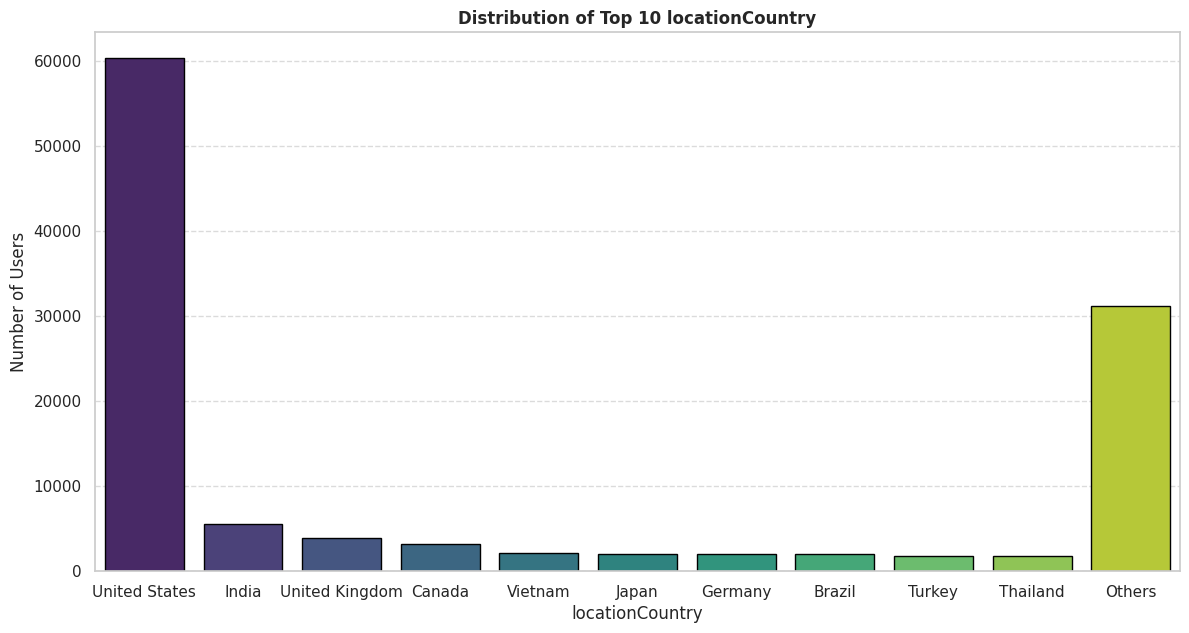

In [74]:
country_counts = df['locationCountry'].value_counts()
top_10_country = country_counts.head(10)
others_country_count = country_counts[10:].sum()
country_grouped = pd.concat([top_10_country, pd.Series({'Others': others_country_count})])

sns.set(style = 'whitegrid')
plt.figure(figsize = (14, 7))
sns.barplot(x = country_grouped.index, y = country_grouped.values, palette = 'viridis',edgecolor = 'black')

plt.title('Distribution of Top 10 locationCountry',fontweight='bold')
plt.xlabel('locationCountry')
plt.ylabel('Number of Users')
plt.grid(axis = 'y', linestyle='--', alpha = 0.7)

plt.show()

- There are 193 Unique values are there in **locationCountry** column, indicating the dataset has user from all the countries of the globe.
- Among which Around 60,000 users are from **United States**.

**20 . device.browserSize**

In [75]:
df['device.browserSize'].nunique()

1

In [76]:
df['device.browserSize'].unique()

array(['not available in demo dataset'], dtype=object)

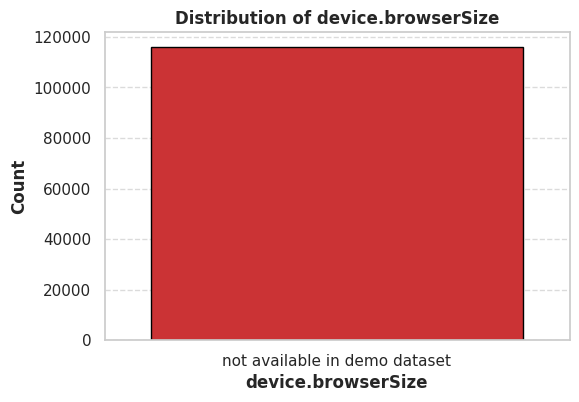

In [77]:
plt.figure(figsize=(6, 4))
sns.countplot(x='device.browserSize', data=df, palette= 'Set1' , edgecolor = 'black')
plt.title('Distribution of device.browserSize', fontweight='bold')
plt.xlabel('device.browserSize' , fontweight = 'bold')
plt.ylabel('Count' , fontweight = 'bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**21. socialEngagementType**

In [78]:
df['socialEngagementType'].nunique()

1

In [79]:
df['socialEngagementType'].unique()

array(['Not Socially Engaged'], dtype=object)

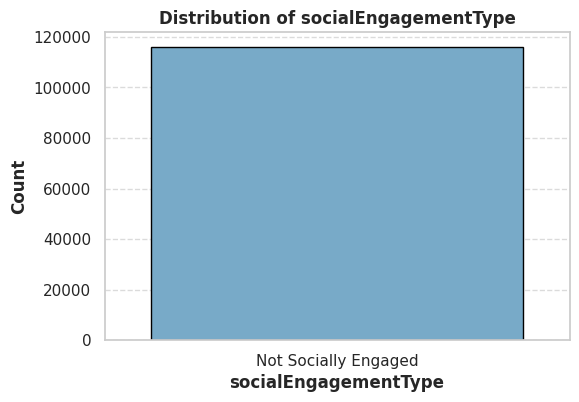

In [80]:
plt.figure(figsize=(6, 4))
sns.countplot(x='socialEngagementType', data=df, palette= 'Blues' , edgecolor = 'black')
plt.title('Distribution of socialEngagementType', fontweight='bold')
plt.xlabel('socialEngagementType' , fontweight = 'bold')
plt.ylabel('Count' , fontweight = 'bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**22. geoNetwork.city**

In [81]:
df['geoNetwork.city'].nunique()

695

In [82]:
df['geoNetwork.city'].unique()

array(['Redmond', 'Mountain View', 'Milan',
       'not available in demo dataset', 'Kuala Lumpur', 'Minato',
       'Hong Kong', 'Campinas', 'Chennai', 'Nakhon Pathom', 'Warsaw',
       'Zurich', 'Istanbul', 'San Francisco', 'Toronto', 'Kirkland',
       'Chicago', 'New York', 'Bogota', 'Cambridge', 'New Delhi',
       'Wellington', 'Pittsburgh', 'Washington', 'Paris', 'London',
       'San Bruno', 'Los Angeles', 'Sydney', 'Doha', 'Mumbai', 'Phoenix',
       'Atlanta', 'Bandung', 'Lagos', 'Tel Aviv-Yafo', 'Irvine', 'Greer',
       'Kiev', 'Melbourne', 'Santa Clara', 'Sunnyvale', '(not set)',
       'San Jose', 'Dundalk', 'Seattle', 'San Diego', 'Montreal', 'Rome',
       'Bengaluru', 'Norfolk', 'Brisbane', 'Jeddah', 'Boston', 'Burnaby',
       'Ho Chi Minh City', 'Bucharest', 'Houston', 'Amsterdam',
       'Ann Arbor', 'Dallas', 'Belo Horizonte', 'Mexico City',
       'Eibelstadt', 'Erode', 'Hyderabad', 'Bangkok', 'Minneapolis',
       'Pune', 'Faisalabad', 'Sao Paulo', 'My Tho', 'Phn

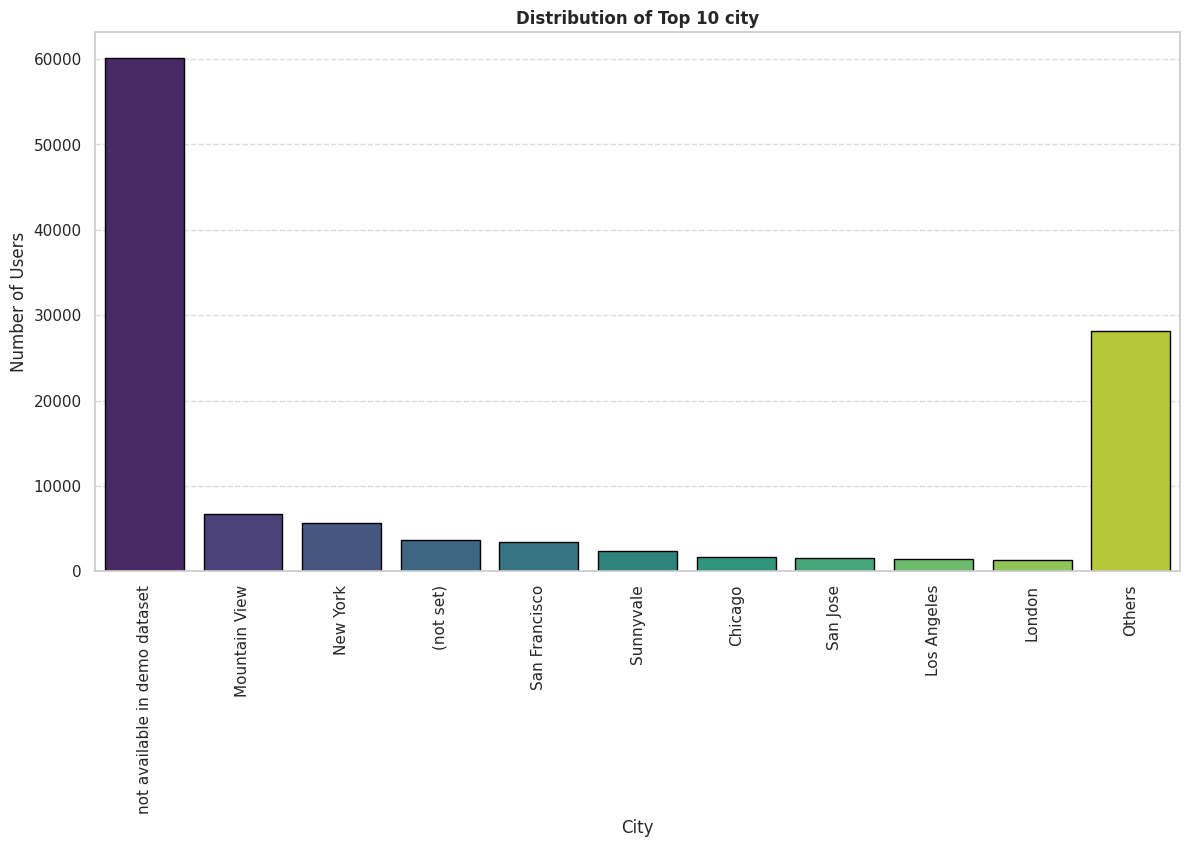

In [83]:
city_counts = df['geoNetwork.city'].value_counts()
top_10_city = city_counts.head(10)
others_city_counts = city_counts[10:].sum()
city_grouped = pd.concat([top_10_city, pd.Series({'Others': others_city_counts})])

sns.set(style = 'whitegrid')
plt.figure(figsize = (14, 7))
sns.barplot(x = city_grouped.index, y = city_grouped.values, palette = 'viridis',edgecolor = 'black')

plt.title('Distribution of Top 10 city',fontweight='bold')
plt.xlabel('City')
plt.ylabel('Number of Users')
plt.xticks(rotation = 90)
plt.grid(axis = 'y', linestyle='--', alpha = 0.7)

plt.show()

- Among Top 10 cities, 7 cities are from **United States**

**23. geoNetwork.metro**

In [84]:
df['geoNetwork.metro'].nunique()

104

In [85]:
df['geoNetwork.metro'].unique()

array(['Seattle-Tacoma WA', 'San Francisco-Oakland-San Jose CA',
       '(not set)', 'not available in demo dataset', 'Chicago IL',
       'New York NY', 'Boston MA-Manchester NH', 'Pittsburgh PA',
       'Washington DC (Hagerstown MD)', 'London', 'Los Angeles CA',
       'Phoenix AZ', 'Atlanta GA',
       'Greenville-Spartanburg-Asheville-Anderson', 'Baltimore MD',
       'San Diego CA', 'Norfolk-Portsmouth-Newport News VA', 'JP_KANTO',
       'Houston TX', 'Detroit MI', 'Dallas-Ft. Worth TX',
       'Minneapolis-St. Paul MN', 'Roanoke-Lynchburg VA', 'Austin TX',
       'Oklahoma City OK', 'San Antonio TX', 'Portland OR', 'Columbus OH',
       'Omaha NE', 'Charlotte NC', 'Dayton OH',
       'Orlando-Daytona Beach-Melbourne FL', 'Midlands', 'Denver CO',
       'Nashville TN', 'Providence-New Bedford,MA',
       'Cleveland-Akron (Canton) OH', 'JP_KINKI',
       'Grand Rapids-Kalamazoo-Battle Creek MI', 'Philadelphia PA',
       'Raleigh-Durham (Fayetteville) NC', 'Kansas City MO', 'Nort

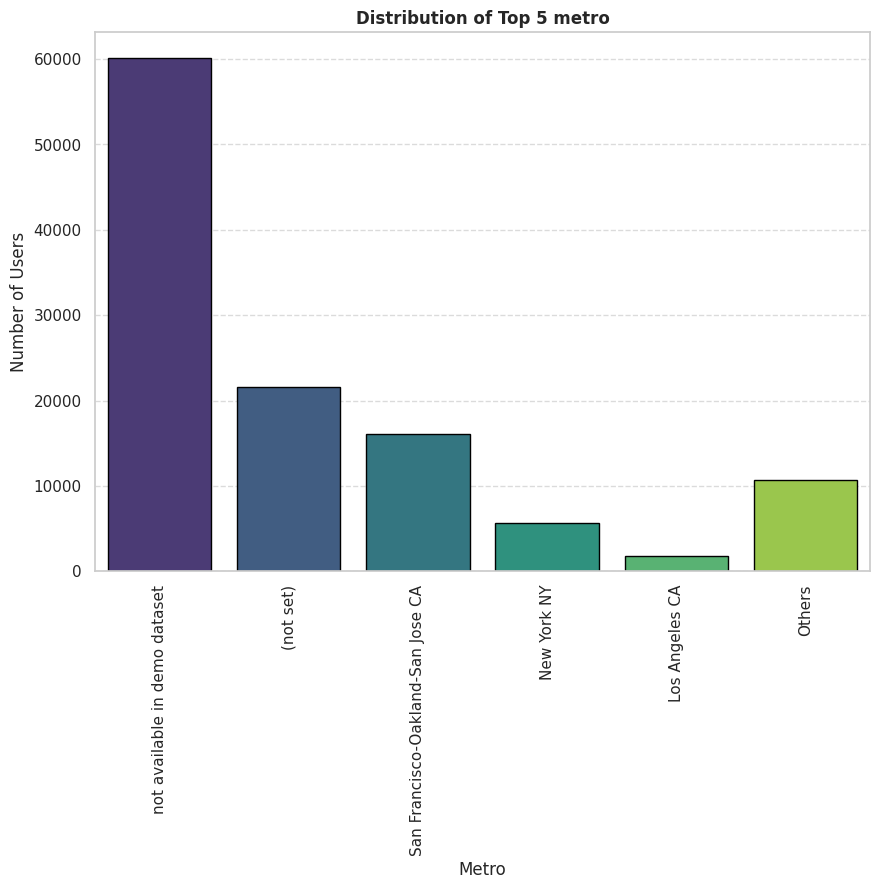

In [86]:
metro_counts = df['geoNetwork.metro'].value_counts()
top_5_metro = metro_counts.head(5)
others_metro_counts = metro_counts[5:].sum()
metro_grouped = pd.concat([top_5_metro, pd.Series({'Others': others_metro_counts})])

sns.set(style = 'whitegrid')
plt.figure(figsize = (10, 7))
sns.barplot(x = metro_grouped.index, y = metro_grouped.values, palette = 'viridis',edgecolor = 'black')

plt.title('Distribution of Top 5 metro',fontweight='bold')
plt.xlabel('Metro')
plt.ylabel('Number of Users')
plt.xticks(rotation = 90)
plt.grid(axis = 'y', linestyle='--', alpha = 0.7)

plt.show()

**24. device.mobileDeviceModel**

In [87]:
df['device.mobileDeviceModel'].nunique()

1

In [88]:
df['device.mobileDeviceModel'].unique()

array(['not available in demo dataset'], dtype=object)

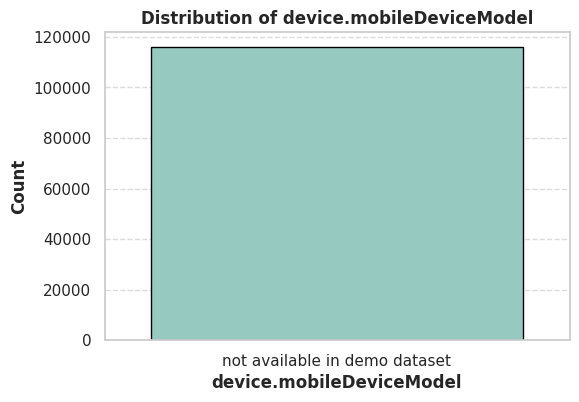

In [89]:
plt.figure(figsize=(6, 4))
sns.countplot(x='device.mobileDeviceModel', data=df, palette= 'Set3' , edgecolor = 'black')
plt.title('Distribution of device.mobileDeviceModel', fontweight='bold')
plt.xlabel('device.mobileDeviceModel' , fontweight = 'bold')
plt.ylabel('Count' , fontweight = 'bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**25. trafficSource.referralPath**

In [90]:
df['trafficSource.referralPath'].nunique()

941

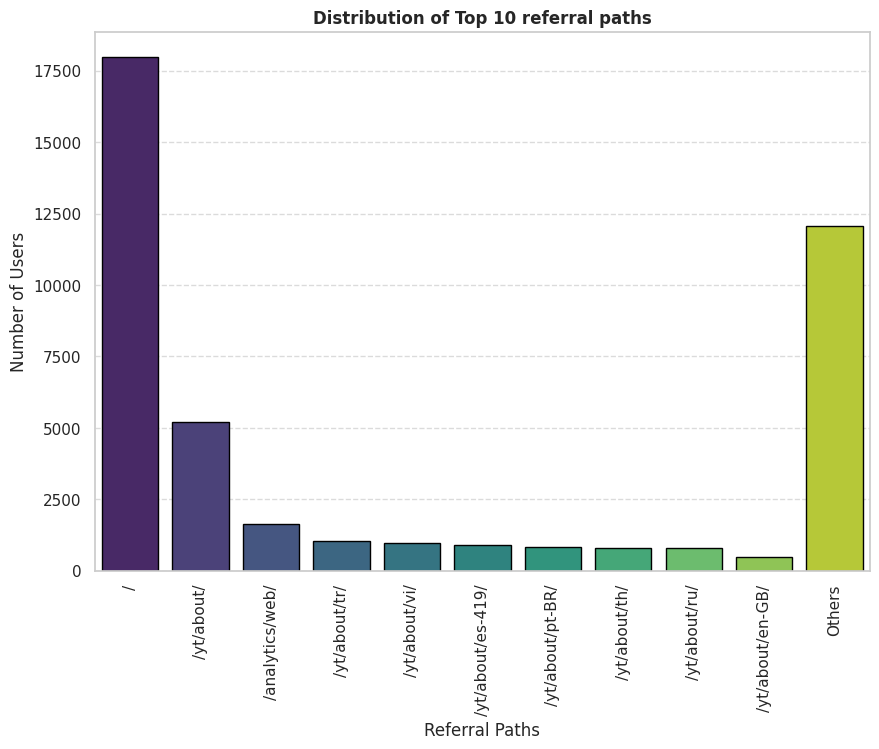

In [91]:
ref_paths = df['trafficSource.referralPath'].value_counts()
top_10_ref_paths = ref_paths.head(10)
other_ref_paths = ref_paths[10:].sum()
ref_path_grouped = pd.concat([top_10_ref_paths, pd.Series({'Others': other_ref_paths})])

sns.set(style = 'whitegrid')
plt.figure(figsize = (10, 7))
sns.barplot(x = ref_path_grouped.index, y = ref_path_grouped.values, palette = 'viridis',edgecolor = 'black')

plt.title('Distribution of Top 10 referral paths',fontweight='bold')
plt.xlabel('Referral Paths')
plt.ylabel('Number of Users')
plt.xticks(rotation = 90)
plt.grid(axis = 'y', linestyle='--', alpha = 0.7)

plt.show()

**26. device.language**

In [92]:
df['device.language'].nunique()

1

In [93]:
df['device.language'].unique()

array(['not available in demo dataset'], dtype=object)

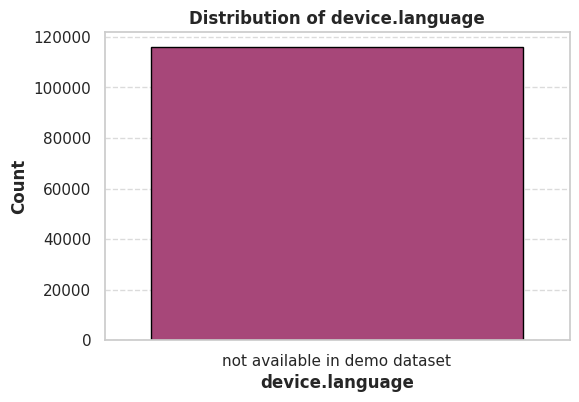

In [94]:
plt.figure(figsize=(6, 4))
sns.countplot(x='device.language', data=df, palette= 'magma' , edgecolor = 'black')
plt.title('Distribution of device.language', fontweight='bold')
plt.xlabel('device.language' , fontweight = 'bold')
plt.ylabel('Count' , fontweight = 'bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**27. deviceType**

In [95]:
df['deviceType'].nunique()

3

In [96]:
df['deviceType'].unique()

array(['desktop', 'mobile', 'tablet'], dtype=object)

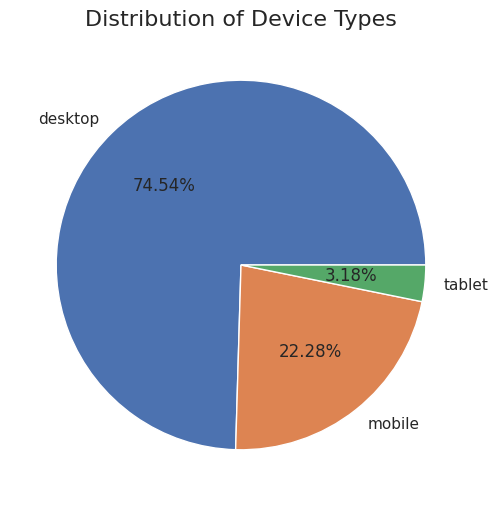

In [97]:
device_counts = df['deviceType'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(device_counts, labels=device_counts.index,autopct='%1.2f%%')
plt.title('Distribution of Device Types', fontsize=16)

plt.show()

- The platform is predominantly accessed through **desktop** devices, which account for **74.54%** of the traffic, indicating a strong preference for larger screens, while **mobile** usage stands at **22.28%**, suggesting moderate on-the-go access, and **tablet** usage is minimal at just **3.18%**, reflecting limited engagement from tablet users

**28. userChannel**

In [98]:
df['userChannel'].nunique()

8

In [99]:
df['userChannel'].unique()

array(['Social', 'Direct', 'Organic Search', 'Referral', 'Affiliates',
       'Paid Search', 'Display', '(Other)'], dtype=object)

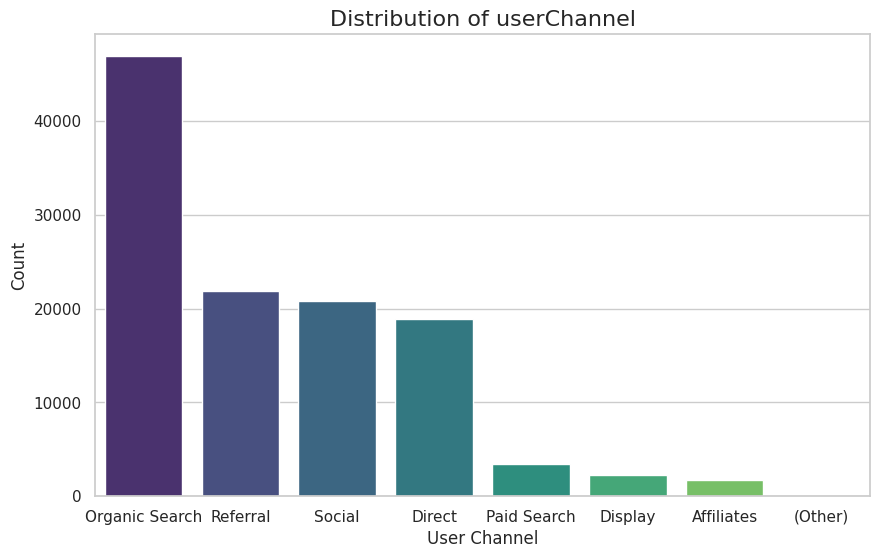

In [100]:
user_channel_counts = df['userChannel'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=user_channel_counts.index, y=user_channel_counts.values, palette='viridis')

plt.title('Distribution of userChannel', fontsize=16)
plt.xlabel('User Channel')
plt.ylabel('Count')

plt.show()

- Most of the User coming directly via **Organic Search**
- Least people are coming via **Affiiates** and **Paid Search** and **Display**

**29. device.browserVersion**

In [101]:
df['device.browserVersion'].nunique()

1

In [102]:
df['device.browserVersion'].unique()

array(['not available in demo dataset'], dtype=object)

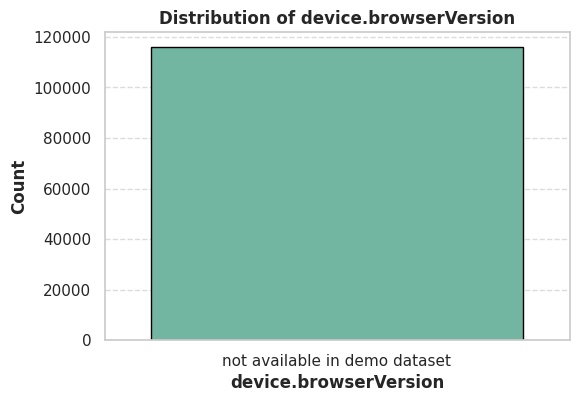

In [103]:
plt.figure(figsize=(6, 4))
sns.countplot(x='device.browserVersion', data=df, palette= 'Set2' , edgecolor = 'black')
plt.title('Distribution of device.browserVersion', fontweight='bold')
plt.xlabel('device.browserVersion' , fontweight = 'bold')
plt.ylabel('Count' , fontweight = 'bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**30 . device.screenColors**

In [104]:
df['device.screenColors'].nunique()


1

In [105]:
df['device.screenColors'].unique()


array(['not available in demo dataset'], dtype=object)

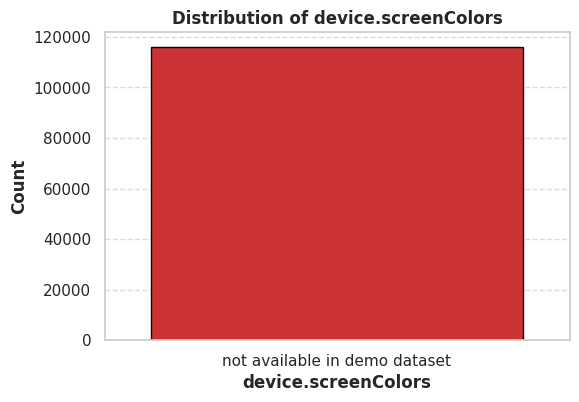

In [106]:
plt.figure(figsize=(6, 4))
sns.countplot(x='device.screenColors', data=df, palette= 'Set1' , edgecolor = 'black')
plt.title('Distribution of device.screenColors', fontweight='bold')
plt.xlabel('device.screenColors' , fontweight = 'bold')
plt.ylabel('Count' , fontweight = 'bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**31. geoNetwork.continent**

In [107]:
df['geoNetwork.continent'].nunique()

6

In [108]:
df['geoNetwork.continent'].unique()

array(['Americas', 'Europe', 'Asia', 'Africa', 'Oceania', '(not set)'],
      dtype=object)

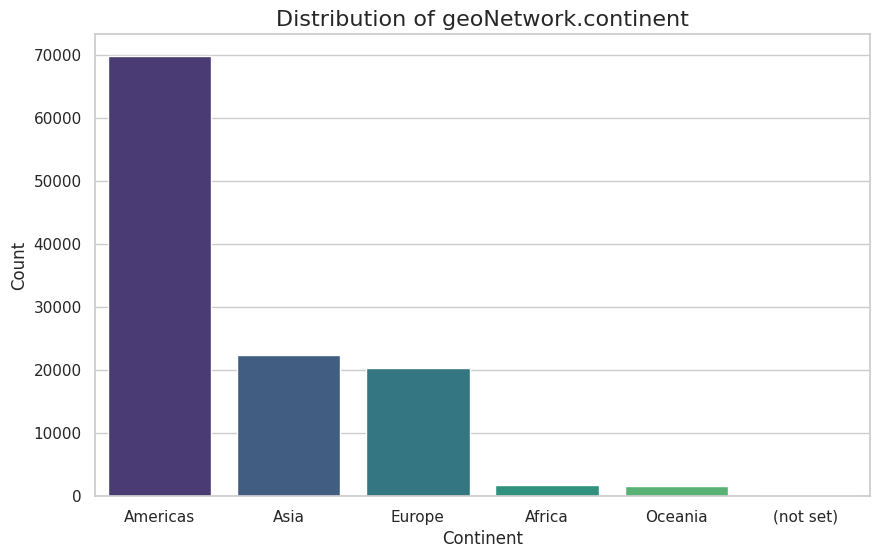

In [109]:
continent_counts = df['geoNetwork.continent'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=continent_counts.index, y=continent_counts.values, palette='viridis')

plt.title('Distribution of geoNetwork.continent', fontsize=16)
plt.xlabel('Continent')
plt.ylabel('Count')

plt.show()

- From **Americas** Continent most of the Users are coming to the Website.

**32. trafficSource.keyword**

In [110]:
df["trafficSource.keyword"].nunique()

566

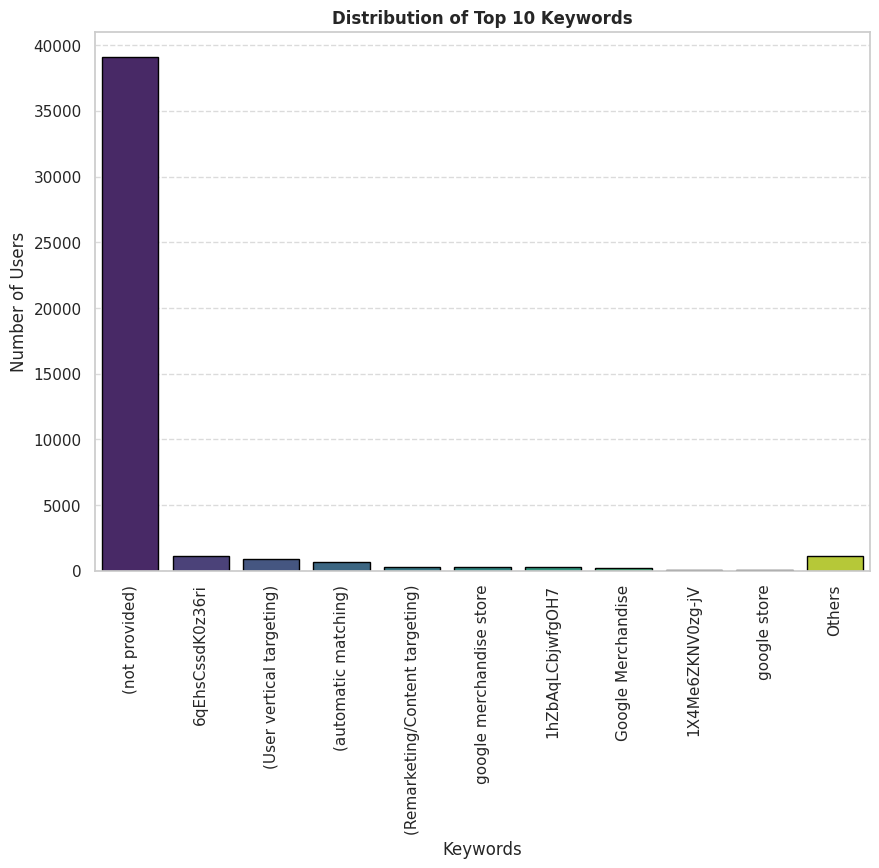

In [111]:
keyword_counts = df['trafficSource.keyword'].value_counts()
top_10_keywords = keyword_counts.head(10)
other_keywords = keyword_counts[10:].sum()
keyword_grouped = pd.concat([top_10_keywords, pd.Series({'Others':other_keywords})])

sns.set(style = 'whitegrid')
plt.figure(figsize = (10, 7))
sns.barplot(x = keyword_grouped.index, y = keyword_grouped.values, palette = 'viridis',edgecolor = 'black')

plt.title('Distribution of Top 10 Keywords',fontweight='bold')
plt.xlabel('Keywords')
plt.ylabel('Number of Users')
plt.xticks(rotation = 90)
plt.grid(axis = 'y', linestyle='--', alpha = 0.7)

plt.show()

**33. device.mobileInputSelector**

In [112]:
df['device.mobileInputSelector'].nunique()

1

In [113]:
df['device.mobileInputSelector'].unique()

array(['not available in demo dataset'], dtype=object)

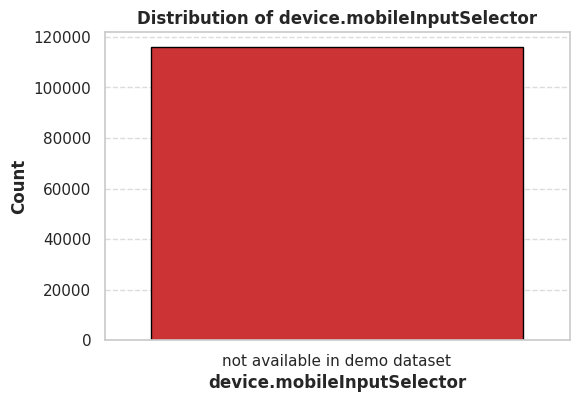

In [114]:
plt.figure(figsize=(6, 4))
sns.countplot(x='device.mobileInputSelector', data=df, palette= 'Set1' , edgecolor = 'black')
plt.title('Distribution of device.mobileInputSelector', fontweight='bold')
plt.xlabel('device.mobileInputSelector' , fontweight = 'bold')
plt.ylabel('Count' , fontweight = 'bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Summary of Analysis of Categorical Column

- Columns Like **trafficSource.isTrueDirect, device.mobileDeviceModel, device.mobileDeviceBranding , mobileDeviceMarketingName, device.flashVersion, device.language, device.operatingSystemVersion, device.screenResolution, device.browserSize, device.browserVersion, browserMajor, geoNetwork.networkLocation, device.screenColors, device.mobileInputSelector** contains only one unique value that is **"not available in demo dataset"**.
- **device.screenSize** column has only one unique value **"medium"**.
- These columns provide no variance or meaningful information for analysis or modeling.

- Columns with very high cardinality such as **trafficSource.keyword**  are better to drop as many of them are not set and random strings of number making no sense. Adding them in model building might decrease the model's predicting power.

## Analysis of Numerial Column

In [115]:
for each in df.select_dtypes(include=['int', 'float']).columns.tolist() :
    print(each)

purchaseValue
userId
gclIdPresent
sessionNumber
totals.visits
sessionId
trafficSource.adwordsClickInfo.page
pageViews
locationZone
totals.bounces
date
totalHits
sessionStart
new_visits


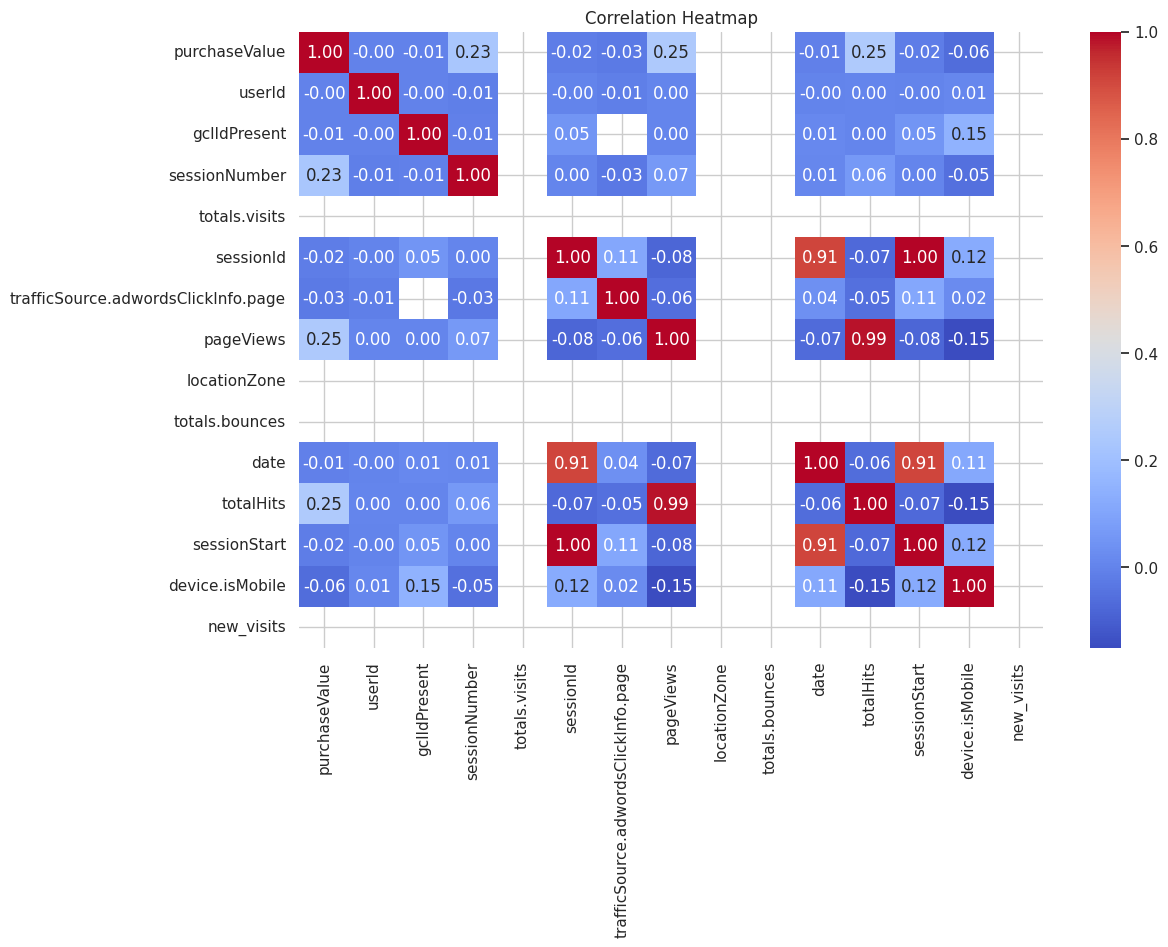

In [116]:
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

- **pageViews, sessionNumber,** and **totalHits** show weak positive correlations with purchaseValue (ranging from 0.23 to 0.25), suggesting that users who interact more are slightly more likely to make higher purchases.

- **pageViews** and **totalHits** are extremely strongly correlated (0.99), meaning they carry redundant information.

- **sessionId, sessionStart,** and **date** have strong mutual correlations (0.91 to 1.0), indicating they are highly time/session-dependent.

- Features like **userId, gclIdPresent,** and **trafficSource.adwordsClickInfo.page** have near-zero correlation with purchaseValue, which implies they are unlikely to be strong predictors of purchasing behavior in our model.

- **device.isMobile** shows a small negative correlation (-0.06) with purchaseValue, implying that desktop users may have a slightly higher tendency to purchase compared to mobile users.

- Columns such as **totals.visits, locationZone, totals.bounces,** and **new_visits** show NaN in the correlation matrix, because they have only one unique value making them uninformative and safe to drop.

**1. purchaseValue**

In [117]:
df['purchaseValue'].nunique()

6766

<Axes: xlabel='purchaseValue', ylabel='Count'>

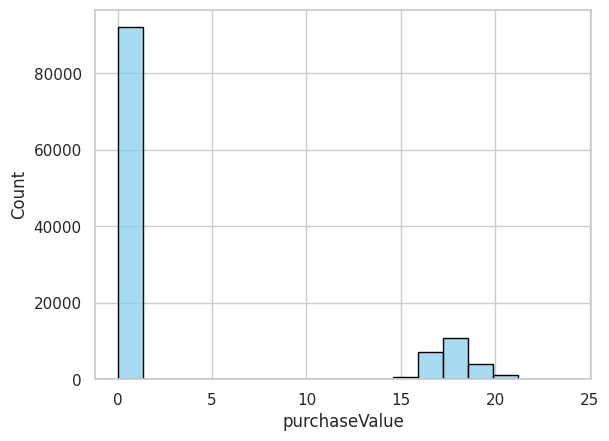

In [118]:
sns.histplot(np.log1p(df['purchaseValue']), color='skyblue', edgecolor='black')

**2. UserId**

In [119]:
df['userId'].nunique()

100499

**3. gclIdPresent**

In [120]:
df['gclIdPresent'].nunique()

2

In [121]:
df['gclIdPresent'].unique()

array([0, 1])

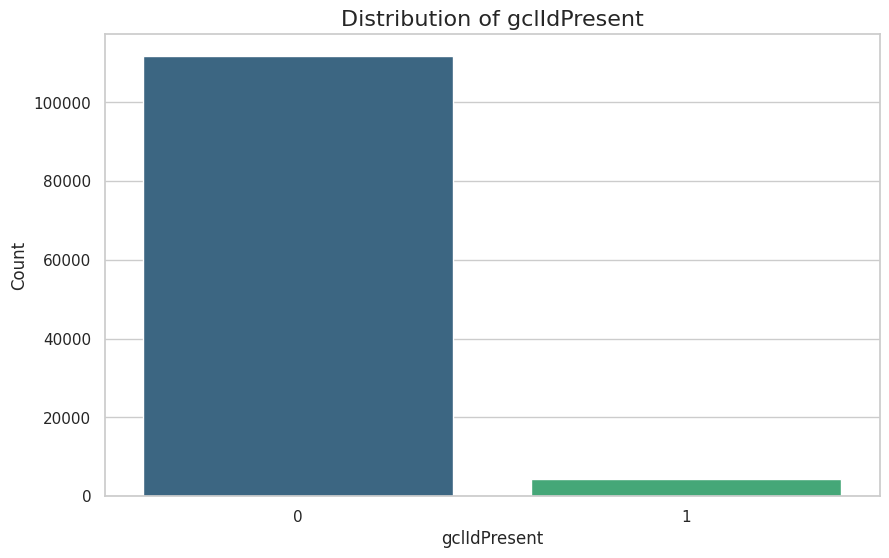

In [122]:
gclid_counts = df['gclIdPresent'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=gclid_counts.index, y=gclid_counts.values, palette='viridis')

plt.title('Distribution of gclIdPresent', fontsize=16)
plt.xlabel('gclIdPresent')
plt.ylabel('Count')

plt.show()

**4. sessionNumber**

In [123]:
df['sessionNumber'].nunique()

230

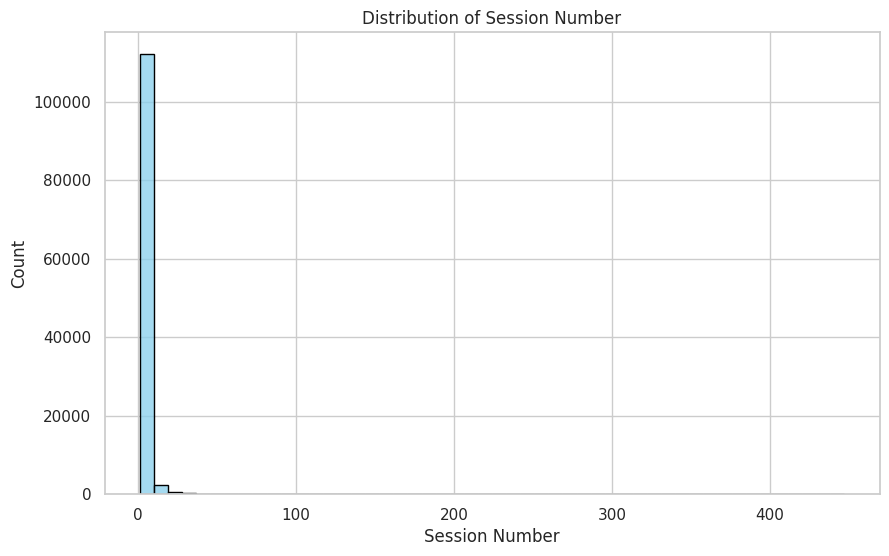

In [124]:
plt.figure(figsize=(10, 6))
sns.histplot(df['sessionNumber'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Session Number')
plt.xlabel('Session Number')
plt.ylabel('Count')
plt.show()

**5. totals.visits**

In [125]:
df['totals.visits'].nunique()

1

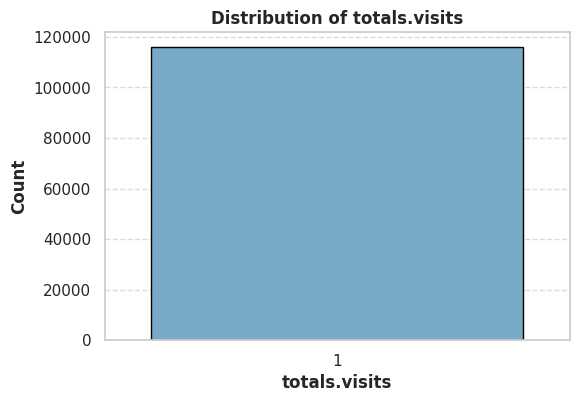

In [126]:
plt.figure(figsize=(6, 4))
sns.countplot(x='totals.visits', data=df, palette= 'Blues' , edgecolor = 'black')
plt.title('Distribution of totals.visits', fontweight='bold')
plt.xlabel('totals.visits' , fontweight = 'bold')
plt.ylabel('Count' , fontweight = 'bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**6. sessionId**

In [127]:
df['sessionId'].nunique()

107379

**7. pageViews**

In [128]:
df['pageViews'].nunique()

175

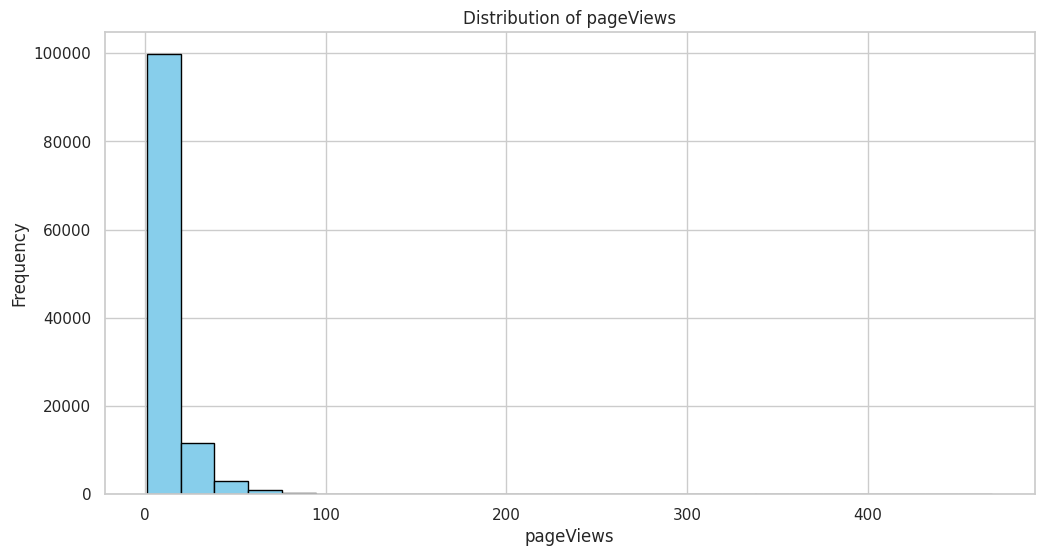

In [129]:
plt.figure(figsize=(12, 6))
plt.hist(df['pageViews'], bins=25, color='skyblue', edgecolor='black')
plt.title('Distribution of pageViews')
plt.xlabel('pageViews')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

**8. locationZone**

In [130]:
df['locationZone'].nunique()

1

In [131]:
df['locationZone'].unique()

array([8])

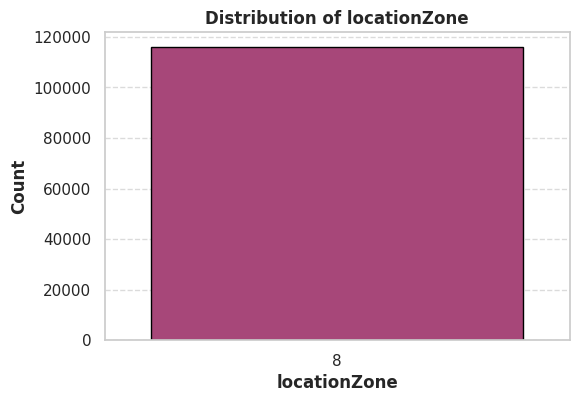

In [132]:
plt.figure(figsize=(6, 4))
sns.countplot(x='locationZone', data=df, palette= 'magma' , edgecolor = 'black')
plt.title('Distribution of locationZone', fontweight='bold')
plt.xlabel('locationZone' , fontweight = 'bold')
plt.ylabel('Count' , fontweight = 'bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**9. totals.bounces**

In [133]:
df['totals.bounces'].nunique()

1

In [134]:
df['totals.bounces'].unique()

array([ 1., nan])

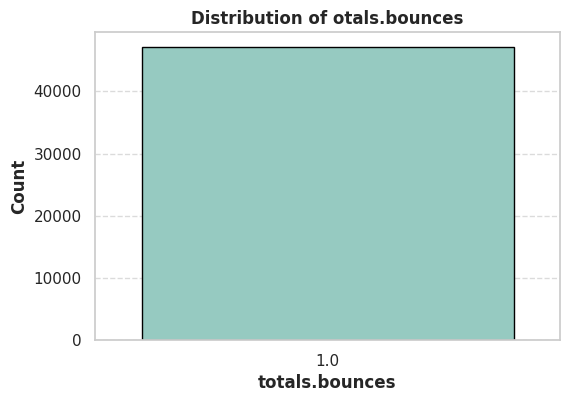

In [135]:
plt.figure(figsize=(6, 4))
sns.countplot(x='totals.bounces', data=df, palette= 'Set3' , edgecolor = 'black')
plt.title('Distribution of otals.bounces', fontweight='bold')
plt.xlabel('totals.bounces' , fontweight = 'bold')
plt.ylabel('Count' , fontweight = 'bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**10. date**

In [136]:
df['date'].nunique()

638

In [137]:
# df['date'] = pd.to_datetime(df['date'])
# df['month'] = df['date'].dt.month
# df['year'] = df['date'].dt.year
# df['weekday'] = df['date'].dt.day_name()

In [138]:
# df['month'].nunique()

In [139]:
# df['month'].unique()

In [140]:
# df['year'].nunique()

In [141]:
# df['year'].unique()

In [142]:
# df['weekday'].nunique()

In [143]:
# df['weekday'].unique()

In [144]:
# fig, axes = plt.subplots(1 , 3, figsize=(12, 4))

# sns.countplot(x='month', data=df, ax=axes[0], palette='Set1')
# axes[0].set_title('Distribution of Month', fontsize=16)
# axes[0].set_xlabel('Month', fontsize=14)
# axes[0].set_ylabel('Count', fontsize=14)

# sns.countplot(x='year', data=df, ax=axes[1], palette='Set2')
# axes[1].set_title('Distribution of Year', fontsize=16)
# axes[1].set_xlabel('Year', fontsize=14)
# axes[1].set_ylabel('Count', fontsize=14)

# order_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# sns.countplot(x='weekday', data=df, ax=axes[2], order=order_days, palette='Set3')
# axes[2].set_title('Distribution of Weekday', fontsize=16)
# axes[2].set_xlabel('Weekday', fontsize=14)
# axes[2].set_ylabel('Count', fontsize=14)
# axes[2].tick_params(axis='x', rotation=90)

# plt.tight_layout()
# plt.show()

**11. totalHits**

In [145]:
df['totalHits'].nunique()

225

In [146]:
df['totalHits'].unique()

array([  1,   6,  66,  48,  17,   4,   5,   2,  14,  10,  11,  39,  19,
        28,  40,   3, 130,  33,  54,  18,  32,  13,  16,  12,   7,  53,
         9,  31, 120,  22,  45,  24,  23,  47,  41,  35,  30,   8,  25,
        61,  36,  87,  27,  34,  21, 107,  55,  26,  58, 127,  81,  94,
        29, 119,  62,  20,  86,  63,  15,  44,  77,  57,  83,  50, 105,
        97,  85,  49,  79,  42,  75,  67,  38,  76,  68,  51,  65,  37,
        43,  59, 124, 160,  56, 104, 242,  70, 135, 103, 106,  78,  52,
        74,  84,  72, 108,  69,  96,  64, 112, 126, 172,  46,  82, 144,
       102,  90,  60, 101,  88, 156, 139, 152,  73,  89, 196, 111, 136,
       210,  91, 153, 114,  98,  95, 134, 132,  80, 159, 166,  92, 331,
       154, 141, 237, 500, 100, 116, 123, 146, 150, 113, 117, 137, 118,
        93, 125,  99, 128, 182, 143,  71, 191, 122, 148, 471, 109, 174,
       161, 176, 163, 158, 121, 167, 129, 193, 142, 187, 131, 220, 110,
       238, 303, 147, 279, 115, 195, 268, 378, 175, 171, 140, 32

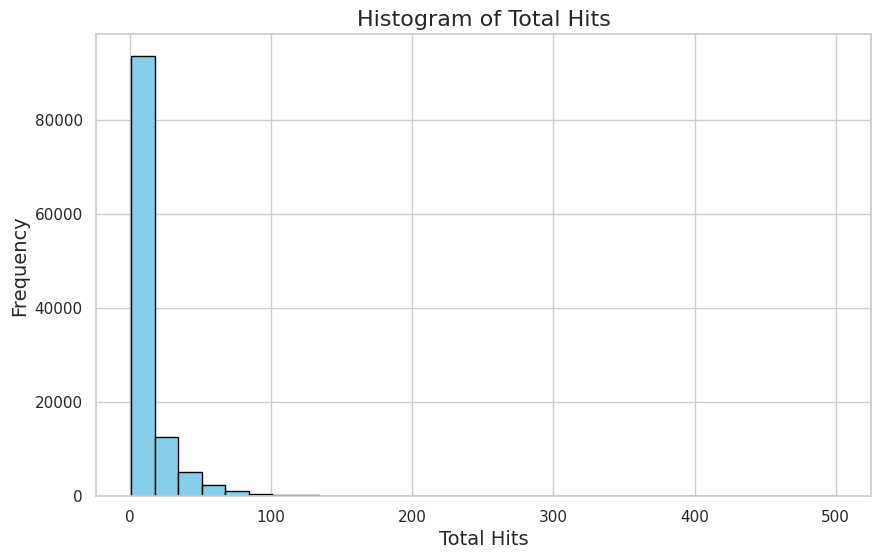

In [147]:
plt.figure(figsize=(10, 6))
plt.hist(df['totalHits'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Total Hits', fontsize=16)
plt.xlabel('Total Hits', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

**12. sessionStart**

In [148]:
df['sessionStart'].nunique()

107388

**13. new_visits**

In [149]:
df['new_visits'].nunique()

1

In [150]:
df['new_visits'].unique()

array([ 1., nan])

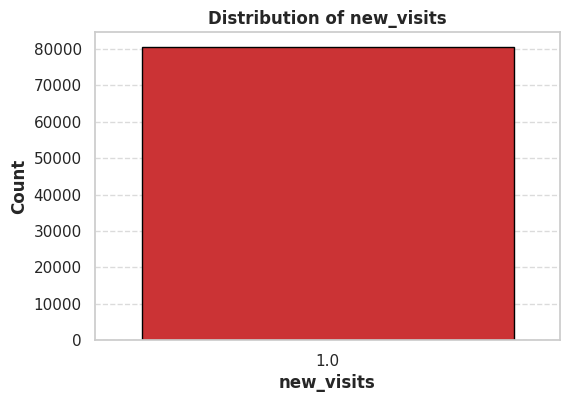

In [151]:
plt.figure(figsize=(6, 4))
sns.countplot(x='new_visits', data=df, palette= 'Set1' , edgecolor = 'black')
plt.title('Distribution of new_visits', fontweight='bold')
plt.xlabel('new_visits' , fontweight = 'bold')
plt.ylabel('Count' , fontweight = 'bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Summary of Analysis of Numerical Column

- Our target column **purchaseValue** is highly-right skewed as most of values concentrated around 0 and few are peaking around 15 - 20.
- Columns like **userId, sessionStart** and **sessionId** have high cardinality and contains nearly all values as unique, this features are highly unlikely to provide any signal during model building.
- Columns such as **totals.visits, locationZone, totals.bounces,** and **new_visits**  have only one unique value making them uninformative and safe to drop.
- The **sessionNumber** distribution is heavily right-skewed, with most users having very few sessions and only a small number reaching high session counts.
- After analysing **date** column, no meaningful conclusion has been found, so it is better to drop it before building model.
- The **pageViews** distribution is heavily right-skewed, with most users viewing fewer than 10 pages per session and a long tail of rare outliers with very high page views.

## Studying Outliers

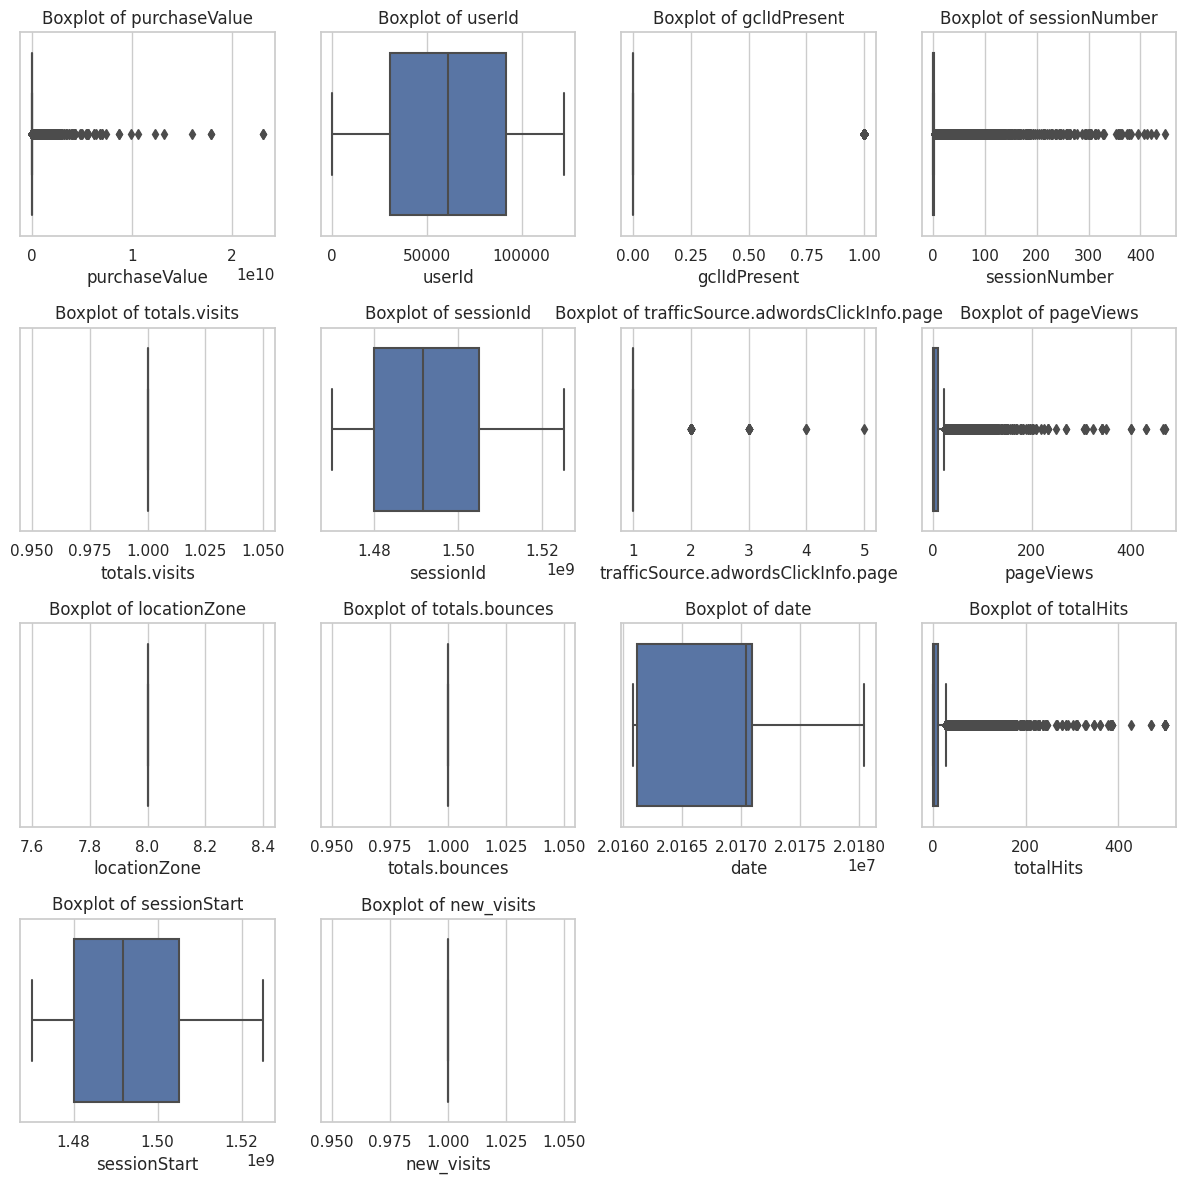

In [152]:
plt.figure(figsize=(12, 12))

for i, column in enumerate(df.select_dtypes(include = ['int64' , 'float']).columns, 1):
    plt.subplot(4, 4, i)  
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

- Most users have low values for **purchaseValue, pageViews, totalHits,** and **sessionNumber**, but a few users have extremely high values, indicating heavy right-skewness and many outliers.
- Columns like **totals.visits, locationZone, totals.bounces,** and **new_visits** show no variation and can be considered uninformative.
- The features **gclIdPresent** and **trafficSource.adwordsClickInfo.page** are sparse or near-binary, offering limited variability.
- Features like **sessionId** and **sessionStart** seem to act as timestamp-like IDs and may not provide meaningful numerical patterns.

# **PreProcessing**

In [153]:
X_train = df.drop(columns = [
    "trafficSource.adContent" , 
    "trafficSource.adwordsClickInfo.isVideoAd" , 
    "trafficSource.adwordsClickInfo.page" , 
    "trafficSource.adwordsClickInfo.adNetworkType" , 
    "trafficSource.adwordsClickInfo.slot" ,
    "trafficSource.isTrueDirect" ,
    "trafficSource.keyword" ,
    "totals.bounces" ,
    "trafficSource.isTrueDirect" ,
    "device.screenResolution" ,
    "screenSize",
    "device.mobileDeviceBranding" ,
    "device.mobileInputSelector" ,
    "device.operatingSystemVersion" ,
    "device.flashVersion" ,
    "geoNetwork.networkLocation" ,
    "browserMajor" , 
    "device.browserSize" ,
    "socialEngagementType" ,
    "device.mobileDeviceModel" ,
    "device.language" ,
    "device.browserVersion" ,
    "device.screenColors" ,
    "userId" ,
    "totals.visits" ,
    "sessionId" ,
    "locationZone" ,
    "totals.bounces" ,
    "date" ,
    "sessionStart" ,
    "new_visits"
])

In [154]:
X = X_train.drop(columns = ["purchaseValue"])
y = X_train["purchaseValue"]

In [155]:
X_test = test_df.copy()

In [156]:
X_test = X_test.drop(columns = [
    "trafficSource.adContent" , 
    "trafficSource.adwordsClickInfo.isVideoAd" , 
    "trafficSource.adwordsClickInfo.page" , 
    "trafficSource.adwordsClickInfo.adNetworkType" , 
    "trafficSource.adwordsClickInfo.slot" ,
    "trafficSource.isTrueDirect" ,
    "trafficSource.keyword" ,
    "totals.bounces" ,
    "trafficSource.isTrueDirect" ,
    "device.screenResolution" ,
    "screenSize",
    "device.mobileDeviceBranding" ,
    "device.mobileInputSelector" ,
    "device.operatingSystemVersion" ,
    "device.flashVersion" ,
    "geoNetwork.networkLocation" ,
    "browserMajor" , 
    "device.browserSize" ,
    "socialEngagementType" ,
    "device.mobileDeviceModel" ,
    "device.language" ,
    "device.browserVersion" ,
    "device.screenColors" ,
    "userId" ,
    "totals.visits" ,
    "sessionId" ,
    "locationZone" ,
    "totals.bounces" ,
    "date" ,
    "sessionStart" ,
    "new_visits"
])

In [157]:
# data = df.drop(df.select_dtypes('object').columns, axis=1)
# X_test = X_test.drop(X_test.select_dtypes('object').columns, axis=1)

In [158]:
# data = data.drop(['trafficSource.adwordsClickInfo.page'], axis=1)
# X_test = X_test.drop(['trafficSource.adwordsClickInfo.page'], axis=1)

In [159]:
# X = data.drop(["purchaseValue"] , axis = 1)

In [160]:
# y = data["purchaseValue"]

In [161]:
X_train, X_val, y_train, y_val = train_test_split(X,y,random_state=0,test_size=0.2)

In [162]:
num_cols = []
for each in X.select_dtypes(include = ["int64" , "float64"]) :
    num_cols.append(each)

num_cols

['gclIdPresent', 'sessionNumber', 'pageViews', 'totalHits']

In [163]:
cat_cols = []
for each in X.select_dtypes(include = "object") :
    cat_cols.append(each)

cat_cols

['browser',
 'geoCluster',
 'trafficSource.campaign',
 'device.mobileDeviceMarketingName',
 'geoNetwork.networkDomain',
 'geoNetwork.region',
 'trafficSource',
 'os',
 'geoNetwork.subContinent',
 'trafficSource.medium',
 'locationCountry',
 'geoNetwork.city',
 'geoNetwork.metro',
 'trafficSource.referralPath',
 'deviceType',
 'userChannel',
 'geoNetwork.continent']

In [164]:
low_cardinality_cols = []
high_cardinality_cols = []

for each in cat_cols :
    if X_train[each].nunique() <= 10 :
        low_cardinality_cols.append(each)
    else :
        high_cardinality_cols.append(each)

In [165]:
low_cardinality_cols

['geoCluster',
 'device.mobileDeviceMarketingName',
 'geoNetwork.networkDomain',
 'trafficSource.medium',
 'deviceType',
 'userChannel',
 'geoNetwork.continent']

In [166]:
high_cardinality_cols

['browser',
 'trafficSource.campaign',
 'geoNetwork.region',
 'trafficSource',
 'os',
 'geoNetwork.subContinent',
 'locationCountry',
 'geoNetwork.city',
 'geoNetwork.metro',
 'trafficSource.referralPath']

In [167]:
num_pipeline = Pipeline([
    ("simpleimputer" , SimpleImputer(strategy = "mean")) ,
    ("standarscaler" , StandardScaler())
])

In [168]:
low_cardinality_cat_pipeline = Pipeline([
    ('simpleimputer', SimpleImputer(strategy='most_frequent')),
    ('onehotencoding', OneHotEncoder(sparse_output = False ,handle_unknown='ignore'))
])

In [169]:
high_cardinality_cat_pipeline = Pipeline([
    ('simpleimputer', SimpleImputer(strategy='most_frequent')),
    ('targetencoding', TargetEncoder())
])

In [170]:
ct = ColumnTransformer([
    ('num_pipe', num_pipeline, num_cols) ,
    ('low_cardinality_cat_pipe', low_cardinality_cat_pipeline , low_cardinality_cols) ,
    ('high_cardinality_cat_pipe', high_cardinality_cat_pipeline , high_cardinality_cols)
]).set_output(transform = 'pandas')

In [171]:
X_train_transformed = ct.fit_transform(X_train , y_train)

In [172]:
# ct = ColumnTransformer([
#     ('median', SimpleImputer(strategy='median'), ['pageViews']),
#     ('cosntant', SimpleImputer(strategy='constant', fill_value=0), ['totals.bounces', 'new_visits'])
# ], remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')

# pipe = Pipeline([
#     ('ct', ct),
#     ('scale', StandardScaler())
# ]).set_output(transform='pandas')


# X_train = pipe.fit_transform(X_train)
# X_val = pipe.transform(X_val)
# X_test = pipe.transform(X_test)

# Model Building

### XGB Regressor

In [173]:
xgb = XGBRegressor(random_state=42, n_estimator=500)
xgb.fit(X_train_transformed, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimator=500, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [174]:
xgb.score(ct.transform(X_val), y_val)

0.6321006632398675

In [175]:
# xgbn = XGBRegressor(random_state=42, n_estimator=650, learning_rate=0.1, subsample=0.80, colsample_bytree=0.9, max_depth=16)
# xgbn.fit(X_train, y_train)
# xgbn.score(X_val, y_val)

### RandomForest

In [176]:
rf = RandomForestRegressor(random_state=42, n_estimators=200)
rf.fit(X_train_transformed, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [177]:
rf.score(ct.transform(X_val), y_val)

0.6187080511901506

In [178]:
# rfn = RandomForestRegressor(random_state=42, n_estimators=650, max_depth=16,max_features=0.8, max_samples=0.7)

# rfn.fit(X_train, y_train)
# rfn.score(X_val, y_val)

### LightBGM

In [179]:
lgbm = lgb.LGBMRegressor(learning_rate=0.05, n_estimators=500, max_depth=10, subsample=0.8, colsample_bytree=0.8,random_state=42)
lgbm.fit(X_train_transformed, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1324
[LightGBM] [Info] Number of data points in the train set: 92818, number of used features: 44
[LightGBM] [Info] Start training from score 26827349.206576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=10,
              n_estimators=500, random_state=42, subsample=0.8)

In [180]:
lgbm.score(ct.transform(X_val), y_val)

0.4699463363693399

# HyperParameter Tuning

In [181]:
# xgb = XGBRegressor(
#     random_state=42,
#     tree_method='hist', 
#     n_jobs=-1
# )

# param_grid = {
#     'n_estimators': [500, 700, 800 ,900],
#     'learning_rate': [0.01, 0.03, 0.05, 0.1],
#     'max_depth': [6, 8, 10],
#     'subsample': [0.7, 0.8, 0.9],
#     'colsample_bytree': [0.7, 0.8, 0.9],
# }

# random_search = RandomizedSearchCV(
#     estimator=xgb,
#     param_grid,
#     n_iter=40,
#     scoring='r2',
#     cv=3,
#     verbose=1,
#     n_jobs=-1,
#     random_state=42
# )

# random_search.fit(X_train, y_train)

# best_model = random_search.best_estimator_
# best_params = random_search.best_params_
# val_r2 = best_model.score(X_val, y_val)

In [182]:
# best_params

In [183]:
# val_r2

In [184]:
# best_params = {'subsample': 0.7, 
#                'n_estimators': 900, 
#                'max_depth': 10,
#                'learning_rate': 0.01, 
#                'colsample_bytree': 0.7
#               }

In [185]:
xgbhpt = XGBRegressor(subsample=0.7, n_estimators=900, max_depth=10, learning_rate=0.01, colsample_bytree=0.7, random_state=42, n_jobs=-1)
xgbhpt.fit(X_train_transformed, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=900, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [186]:
xgbhpt.score(ct.transform(X_val), y_val)

0.6245733003497795

# Model Comparision

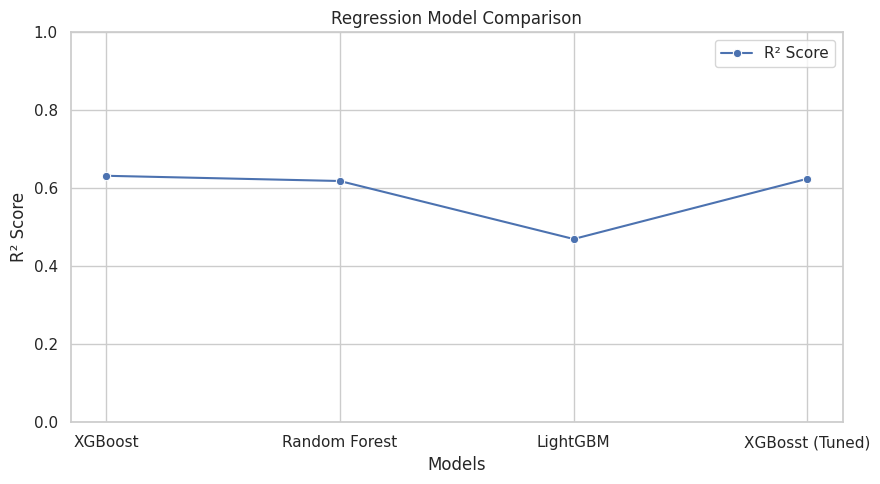

In [187]:
models = np.array(["XGBoost", "Random Forest", "LightGBM", "XGBosst (Tuned)"])
r2_scores = np.array([
    xgb.score(ct.transform(X_val), y_val),
    rf.score(ct.transform(X_val), y_val),
    lgbm.score(ct.transform(X_val), y_val),
    xgbhpt.score(ct.transform(X_val), y_val)
])

plt.figure(figsize=(9, 5))
sns.lineplot(x=models, y=r2_scores, marker='o', label='R² Score')

plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('Regression Model Comparison')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Final Submission

In [188]:
y_pred = xgb.predict(ct.transform(X_test))

submission = pd.DataFrame({
    'id': range(X_test.shape[0]),
    'purchaseValue': y_pred
})
submission.to_csv('submission.csv', index=False)

In [189]:
submission

,id,purchaseValue
0,0,1.565578e+07
1,1,3.457136e+06
2,2,-1.564252e+05
3,3,-8.377162e+06
4,4,5.615679e+06
...,...,...
29001,29001,4.336470e+06
29002,29002,1.482271e+08
29003,29003,6.749906e+07
29004,29004,-9.869504e+04


# Milestone 1

In [190]:
# # What is the correlation between the number of pageviews and the purchase value, considering only users who did not bounce?
# filtered = train_df[train_df["totals.bounces"] != 1]
# filtered = filtered.dropna(subset=["pageViews", "purchaseValue"])
# correlation = filtered["pageViews"].corr(filtered["purchaseValue"])
# correlation

In [191]:
# # Among users from different continents, which continent has the highest average 'totalHits'?
# continent_hits = train_df.groupby("geoNetwork.continent")["totalHits"].mean().sort_values(ascending=False)
# continent_hits.idxmax()

In [192]:
# # For users who made a purchase, what is the most common traffic source (medium)?
# purchasers = train_df[train_df['purchaseValue'] > 0]
# most_common_medium_count = purchasers['trafficSource.medium'].value_counts()
# most_common_medium_count.idxmax()

In [193]:
# # Which combination of operating system and browser is most common among users who made a purchase?
# purchasers['os_browser_combo'] = purchasers['os'].astype(str) + ' | ' + purchasers['browser'].astype(str)
# most_common_combo_count = purchasers['os_browser_combo'].value_counts()
# most_common_combo_count.idxmax()

In [194]:
# # What is the ratio of average number of hits for sessions that resulted in a purchase compared to those that did not?
# non_purchasers = train_df[train_df['purchaseValue'] == 0]

# avg_hits_purchase = purchasers['totalHits'].mean()
# avg_hits_no_purchase = non_purchasers['totalHits'].mean()

# hits_ratio = avg_hits_purchase / avg_hits_no_purchase
# hits_ratio

In [195]:
# # What is the proportion of 'organic' sessions in comparison to all other types of sessions from each traffic source medium?
# organic_sessions = (train_df["trafficSource.medium"] == "organic").sum()
# total_sessions = len(train_df)
# organic_proportion = organic_sessions / total_sessions
# organic_proportion

In [196]:
# # Which referral path is most common for sessions that resulted in a purchase?
# top_referrals = purchasers['trafficSource.referralPath'].value_counts().head(5)
# top_referrals.idxmax()

In [197]:
# # Which operating system has the highest average purchase value?
# os_avg_purchase = train_df.groupby("os")["purchaseValue"].mean().sort_values(ascending=False)
# os_avg_purchase.idxmax()

In [198]:
# # What is the average number of sessions per user?
# sessions_per_user = train_df.groupby('userId')['sessionId'].nunique()
# average_sessions_per_user = sessions_per_user.mean()
# average_sessions_per_user

In [199]:
# # How many unique users are there in the dataset?
# unique_users = train_df["userId"].nunique()
# unique_users

# Milestone 2

In [200]:
# # When visualizing the distribution of totalHits across the dataset, which of the following would be most accurate?
# plt.figure(figsize=(10, 6))
# sns.histplot(train_df['totalHits'], bins=100, kde=True, color='skyblue')
# plt.title('Distribution of totalHits')
# plt.xlabel('totalHits')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()

In [201]:
# # What is the correlation coefficient between pageViews and purchaseValue for mobile users only?
# mobile_users = train_df[train_df['deviceCategory'] == 'mobile']
# mobile_users = mobile_users[['pageViews', 'purchaseValue']].dropna()
# corr = mobile_users['pageViews'].corr(mobile_users['purchaseValue'])
# corr

In [202]:
# # A data scientist created a model to predict purchases using a 70-30 stratified train-validation split. If the validation set contains 20.68% of records with purchases and there were 23,985 purchase records in total, approximately how many purchase records were in the training set?
# N_total = train_df.shape[0]
# purchase_total = 23985
# purchase_in_val = 0.2068 * 0.3 * N_total
# purchase_in_train = purchase_total - purchase_in_val
# purchase_in_train

In [203]:
# # When normalizing the purchase value column, what would be the approximate standard deviation of the normalized values?
# scaler = StandardScaler()
# normalized_values = scaler.fit_transform(train_df[['purchaseValue']])
# std_dev = normalized_values.std()
# std_dev

In [204]:
# # If we build a linear regression model to predict purchase value using totalHits and pageViews as features, which coefficient would likely have a larger magnitude?

# X = train_df[['totalHits', 'pageViews']]
# y = train_df['purchaseValue']

# lmodel = LinearRegression()
# lmodel.fit(X, y)

# coef_dict = dict(zip(X.columns, model.coef_))
# coef_dict

In [205]:
# # What percentage of the dataset has missing values in the totals.bounces column?
# missing_pct = train_df['totals.bounces'].isna().mean() * 100
# missing_pct